In [303]:
import os
import cv2
import numpy as np
from glob import glob
from PIL import Image
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd
import colormap
import metrics 
import utils
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Adversarial Sampling

What makes one segmentation algorithm better than another?

One common method is an average-case performance analysis: some metric like mean Intersection over Union (mIOU) or Average Precision (AP). 

Another option, is to take a worst case analysis (as is often the case in algorithmic analysis). How would we go about doing this?
In general, we'll use people as a gold-standard "ground truth", and for the moment we can use either:
1. Segmentation maps drawn by humans in time-unconstrained settings (which are noisy due to task constraints, like drawing with a computer mouse, or semantic uncertainty)
2. Segmentation maps extracted from simulators

So let's say we have some high-fidelity representation of reasonable segmentation maps. We want to collect a sample of points that maximally 
discriminates models from people, and models from models. How should we sample points on an image to achieve that goal?

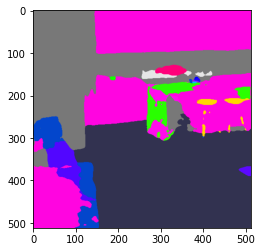

In [11]:
from colormap import recolor, as_labels
pred = cv2.imread("/Users/yonifriedman/Projects/segmentation/model_predictions/DPT/hypersim_v3/image_000-dpt_large-ade20k-b12dca68.png")
plt.imshow(pred)

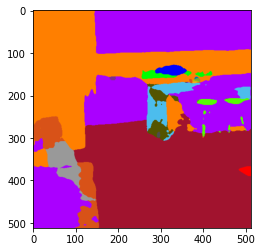

In [12]:
predlabels = recolor(pred)
plt.imshow(predlabels)

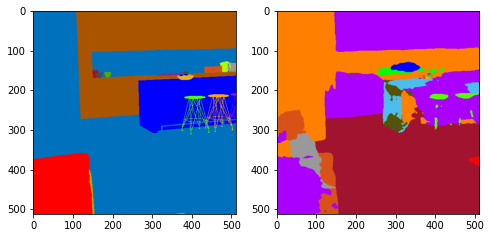

In [13]:
gt = recolor(cv2.imread("/Users/yonifriedman/Projects/segmentation/data/hypersim_v3/masks/mask_000.png"))
pred = recolor(cv2.imread("/Users/yonifriedman/Projects/segmentation/model_predictions/DPT/hypersim_v3/image_000-dpt_large-ade20k-b12dca68.png"))
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
axs[0].imshow(gt)
axs[1].imshow(pred)


0.03270023076565794 0.364800538107311


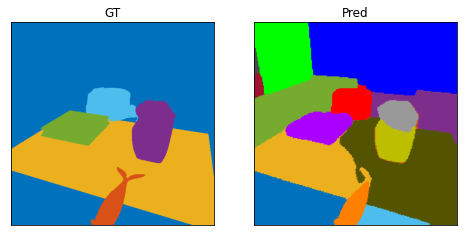

In [14]:
idx = 0
pred = utils.load_model_predictions("TDW", idx, "EISEN")
img, gt = utils.load_input("TDW", idx)

pred = colormap.as_labels(pred)
gt = colormap.as_labels(gt)
ious = metrics.IOU(gt, pred)

print(ious.mean(), ious.max())

gt = colormap.recolor(gt)
pred = colormap.recolor(pred)
fig = utils.plot_pair(gt, pred, labels=["GT", "Pred"])
plt.show()

In [15]:

if False:
    ious = []
    for dataset in ["TDW", "gestalt_shapegen", "hypersim_v3", "NSD"]:
        for model in ["EISEN", "DPT"]:
            for idx in range(100):
                pred = utils.load_model_predictions(dataset, idx, model)
                img, gt = utils.load_input(dataset, idx)

                gt_labels = colormap.as_labels(gt)
                pred_labels = colormap.as_labels(pred)
                miou, new_labels = metrics.hungarian_assigmnent(gt_labels, pred_labels)

                if idx % 10 == 0:
                    pred_relabeled = colormap.recolor(pred, use_labels=new_labels)
                    gt_relabeled = colormap.recolor(gt_labels)
                    fig = utils.plot_pair(gt_relabeled, pred_relabeled)
                    plt.suptitle(f"[Image {idx}] mIOU: {miou:.03f}")
                    plt.show()

                ious.append({"dataset": dataset, "model": model, "image_idx": idx, "mIOU": miou})

    df = pd.DataFrame(ious)
    fig = plt.figure(figsize=(8,6))
    sns.barplot(y="mIOU", x="dataset", hue="model", data=df)
    plt.ylim(0, 1)
    plt.xlabel("Dataset", fontsize=16)
    plt.ylabel("mIOU", fontsize=16)
    plt.title("Mean IOU across models/datasets", fontsize=20)

In [186]:
def load_two(model, dataset, idx):
    pred = utils.load_model_predictions(dataset, idx, model)
    img, gt = utils.load_input(dataset, idx)

    gt_labels = colormap.as_labels(gt)
    pred_labels = colormap.as_labels(pred)
    miou, new_labels = metrics.hungarian_assigmnent(gt_labels, pred_labels)
    pred_relabeled = colormap.relabel(pred_labels, new_labels)

    return gt_labels, pred_relabeled


In [295]:
def points_in_circle(radius, x0=0, y0=0):
    """
    returns points in a circle with a given radius, centered at x0, y0
    """
    xs = np.arange(x0 - radius - 1, x0 + radius + 1, dtype=int)
    ys = np.arange(y0 - radius - 1, y0 + radius + 1, dtype=int)
    x, y = np.where((xs[:,np.newaxis] - x0)**2 + (ys - y0)**2 <= radius**2)
    for x, y in zip(xs[x], ys[y]):
        yield x, y

def check_overlap(point, border_dist, mask, overlap_threshold=5):
    """
    Check if a point is too close to the image border or if the probe overlaps too much
    with the wrong object
    """
    width = mask.shape[0]
    radius = 10
    if point[0] < border_dist or point[1] < border_dist \
        or point[0] > width - border_dist or point[1] > width - border_dist:
        return True

    mask_val = mask[point[1], point[0]]
    overlaps = 0

    for x_t, y_t in points_in_circle(radius=radius, x0=point[0], y0=point[1]):
        if x_t > (width - border_dist) or y_t > (width - border_dist) \
                or x_t < border_dist or y_t < border_dist:
            return True

        if mask[y_t, x_t] != mask_val:
            overlaps += 1
            if overlaps > overlap_threshold:
                return True

    return False

In [306]:
def adversarial_sample(gt, pred):
    """
    Samples pairs of points to highlight failures of model predictions
    One set of points is oversegmented: 
        Pairs of points such that in each pair, the predicted ID of each point is different, but the 
        ground truth is the same (and the ground truth is not a background ID)
    One set is undersegmented:
        Pairs of points such that in each pair, the predicted ID is the same, but the ground truth
        is different
    
    Args:
        gt (`np.ndarray`):
            (H x W) array of mask IDs
        pred (`np.ndarray`):
            (H x W) array of mask IDs 
    """

    sampled_points = []

    gt_ids = np.unique(gt)[1:]   # ignore background
    pred_ids = np.unique(pred)[1:] # ignore background

    for i in range(len(pred_ids)):
        pred_id = pred_ids[i] 
        gt_locs = np.where(pred == pred_id, gt, 0)
        gt_vals = np.unique(gt_locs)[1:]
        if len(gt_vals) > 1:
            counts = 0

            # Undersegmented region -- multiple ground truth labels 
            while True:
                val0, val1 = np.random.choice(gt_vals, 2, replace=False)
                y0s, x0s = np.where(gt_locs == val0)
                y1s, x1s = np.where(gt_locs == val1)
                
                index0 = np.random.choice(range(len(y0s)))
                index1 = np.random.choice(range(len(y1s)))
                x0, y0 = x0s[index0], y0s[index0]
                x1, y1 = x1s[index1], y1s[index1]

                overlap = check_overlap((x0, y0), 10, gt_locs)
                counts += 1
                if counts > 300:
                    break
                
                if overlap:
                    continue

                overlap = check_overlap((x1, y1), 10, gt_locs)
                if overlap:
                    continue
                
                sampled_points.append(((x0, y0), (x1, y1)))
                break

    for i in range(len(gt_ids)):
        gt_id = gt_ids[i] 
        pred_locs = np.where(gt == gt_id, pred, 0)
        pred_vals = np.unique(pred_locs)[1:]
        if len(pred_vals) > 1:
            counts = 0

            # Oversegmented region -- multiple predicted labels
            while True:
                val0, val1 = np.random.choice(pred_vals, 2, replace=False)
                y0s, x0s = np.where(pred_locs == val0)
                y1s, x1s = np.where(pred_locs == val1)
                
                index0 = np.random.choice(range(len(y0s)))
                index1 = np.random.choice(range(len(y1s)))
                x0, y0 = x0s[index0], y0s[index0]
                x1, y1 = x1s[index1], y1s[index1]

                overlap = check_overlap((x0, y0), 10, pred_locs)
                counts += 1
                if counts > 300:
                    break
                
                if overlap:
                    continue

                overlap = check_overlap((x1, y1), 10, pred_locs)
                if overlap:
                    continue
                
                sampled_points.append(((x0, y0), (x1, y1)))
                break

    return sampled_points
            

In [307]:
from tqdm.notebook import tqdm

  0%|          | 0/100 [00:00<?, ?it/s]

Found 2 points for EISEN/gestalt_shapegen/0.


<Figure size 720x576 with 0 Axes>

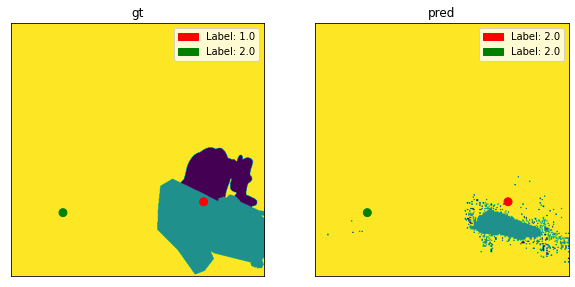

<Figure size 720x576 with 0 Axes>

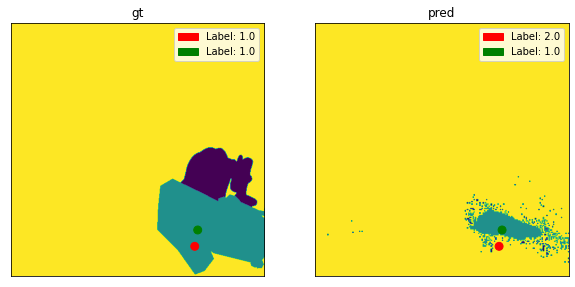

Found 0 points for EISEN/gestalt_shapegen/1.


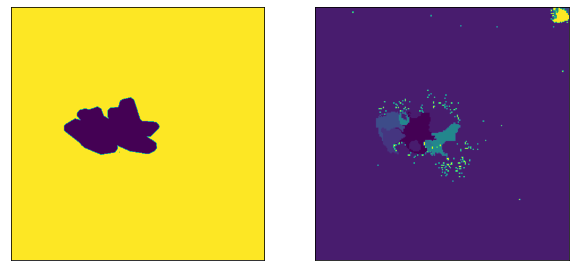

Found 0 points for EISEN/gestalt_shapegen/2.


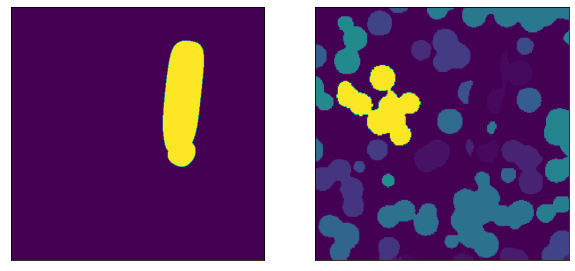

Found 1 points for EISEN/gestalt_shapegen/3.
Found 0 points for EISEN/gestalt_shapegen/4.


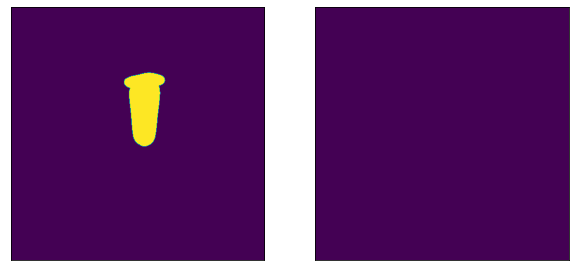

Found 0 points for EISEN/gestalt_shapegen/5.


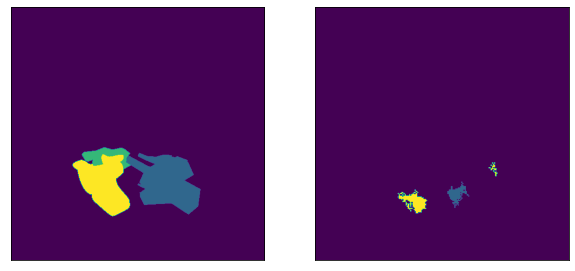

Found 4 points for EISEN/gestalt_shapegen/6.
Found 0 points for EISEN/gestalt_shapegen/7.


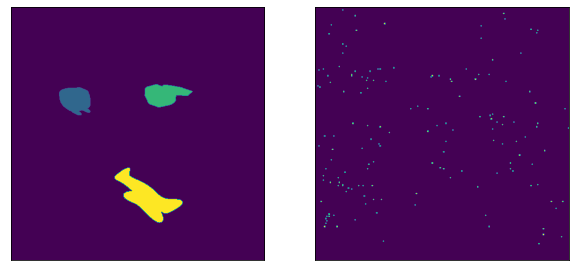

Found 0 points for EISEN/gestalt_shapegen/8.


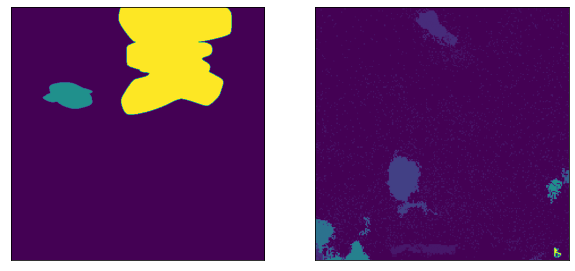

Found 0 points for EISEN/gestalt_shapegen/9.


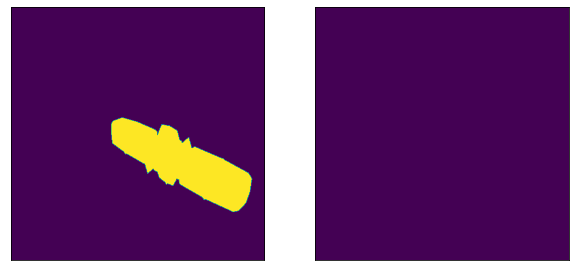

Found 1 points for EISEN/gestalt_shapegen/10.
Found 1 points for EISEN/gestalt_shapegen/11.
Found 0 points for EISEN/gestalt_shapegen/12.


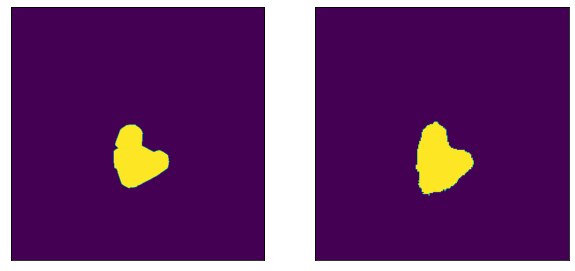

Found 1 points for EISEN/gestalt_shapegen/13.
Found 0 points for EISEN/gestalt_shapegen/14.


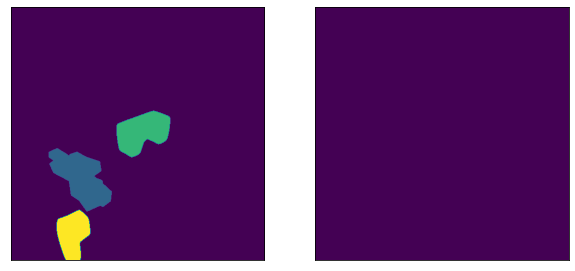

Found 0 points for EISEN/gestalt_shapegen/15.


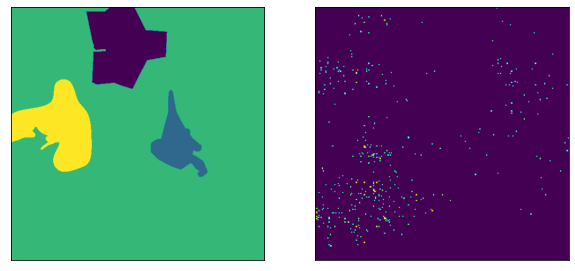

Found 2 points for EISEN/gestalt_shapegen/16.
Found 0 points for EISEN/gestalt_shapegen/17.


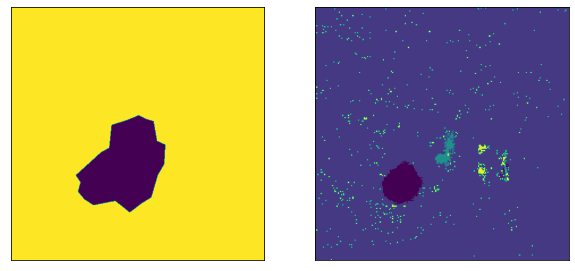

Found 4 points for EISEN/gestalt_shapegen/18.
Found 4 points for EISEN/gestalt_shapegen/19.
Found 3 points for EISEN/gestalt_shapegen/20.


<Figure size 720x576 with 0 Axes>

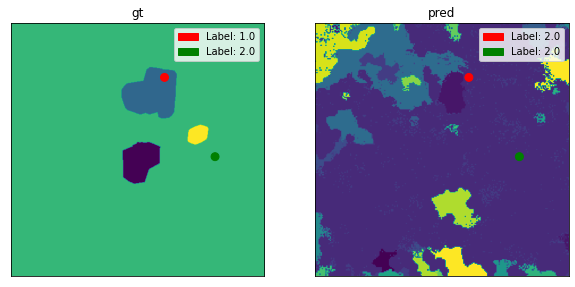

<Figure size 720x576 with 0 Axes>

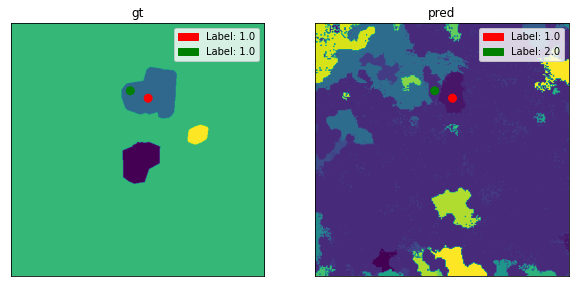

<Figure size 720x576 with 0 Axes>

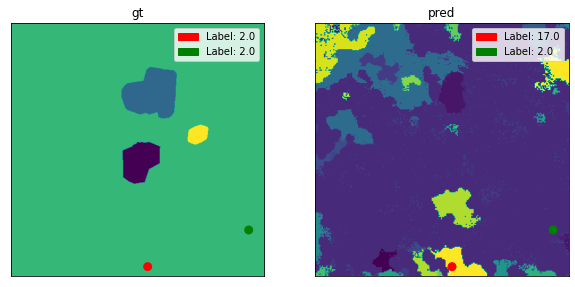

Found 1 points for EISEN/gestalt_shapegen/21.
Found 0 points for EISEN/gestalt_shapegen/22.


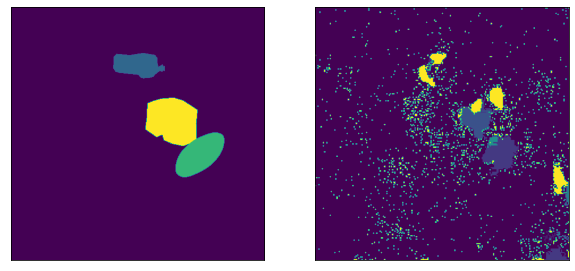

Found 0 points for EISEN/gestalt_shapegen/23.


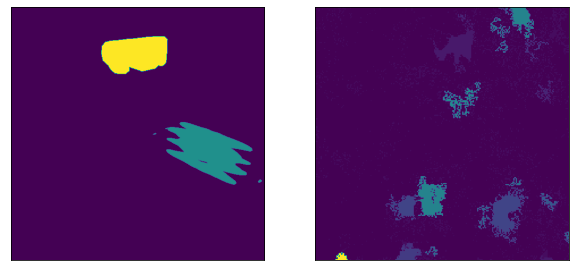

Found 0 points for EISEN/gestalt_shapegen/24.


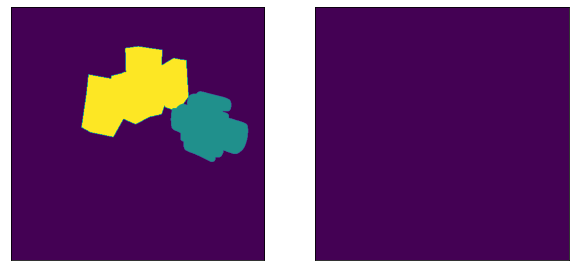

Found 0 points for EISEN/gestalt_shapegen/25.


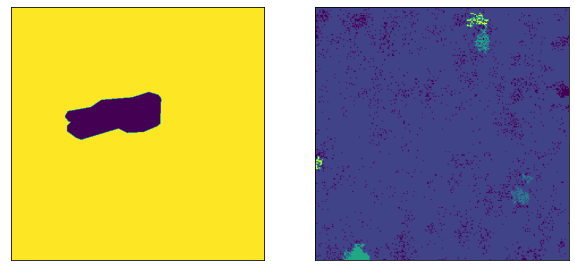

Found 0 points for EISEN/gestalt_shapegen/26.


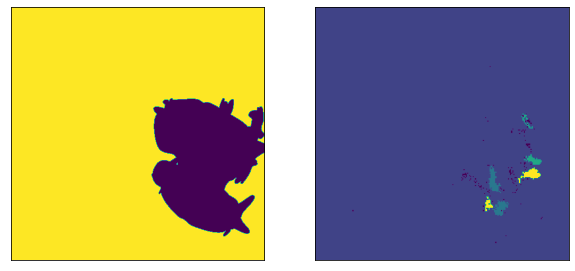

Found 0 points for EISEN/gestalt_shapegen/27.


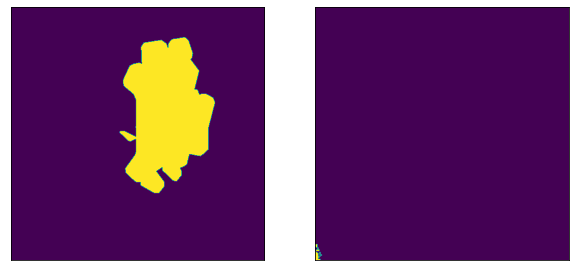

Found 7 points for EISEN/gestalt_shapegen/28.
Found 1 points for EISEN/gestalt_shapegen/29.
Found 3 points for EISEN/gestalt_shapegen/30.
Found 0 points for EISEN/gestalt_shapegen/31.


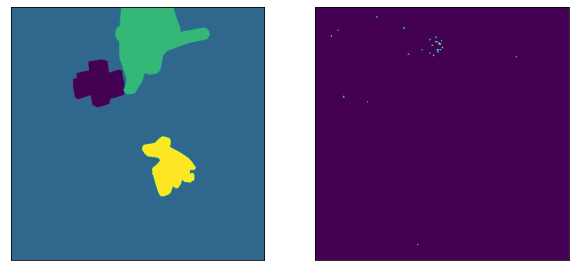

Found 0 points for EISEN/gestalt_shapegen/32.


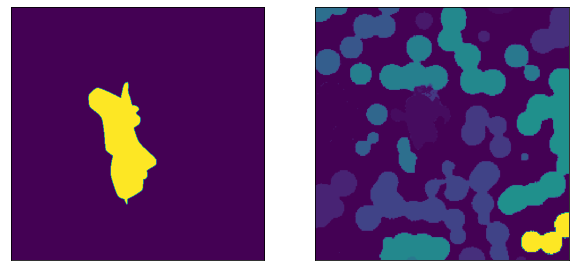

Found 2 points for EISEN/gestalt_shapegen/33.
Found 0 points for EISEN/gestalt_shapegen/34.


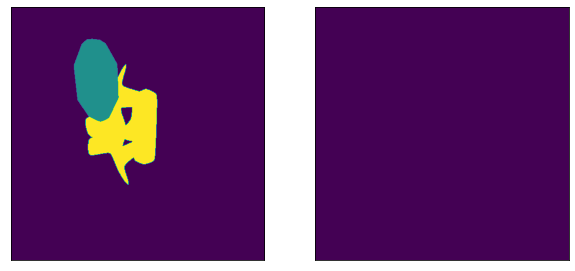

Found 1 points for EISEN/gestalt_shapegen/35.
Found 0 points for EISEN/gestalt_shapegen/36.


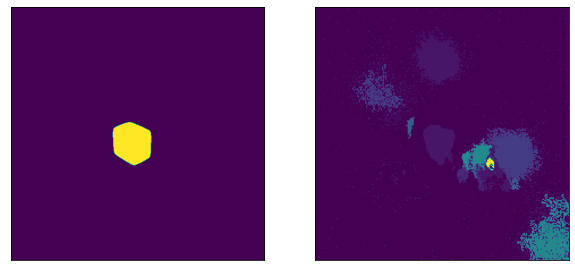

Found 4 points for EISEN/gestalt_shapegen/37.
Found 1 points for EISEN/gestalt_shapegen/38.
Found 1 points for EISEN/gestalt_shapegen/39.
Found 2 points for EISEN/gestalt_shapegen/40.


<Figure size 720x576 with 0 Axes>

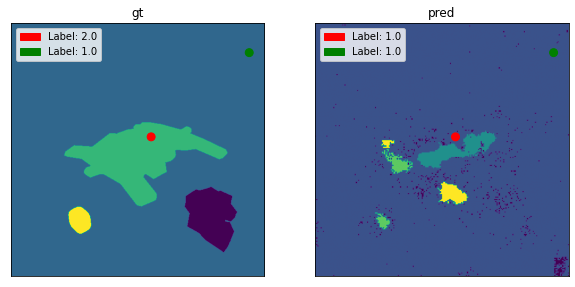

<Figure size 720x576 with 0 Axes>

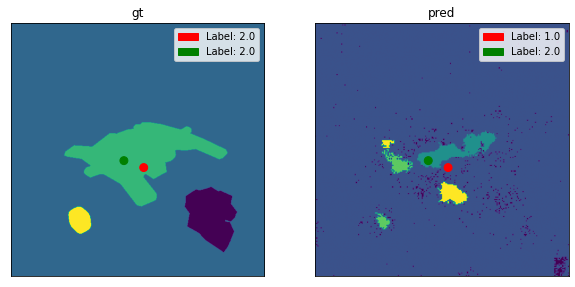

Found 0 points for EISEN/gestalt_shapegen/41.


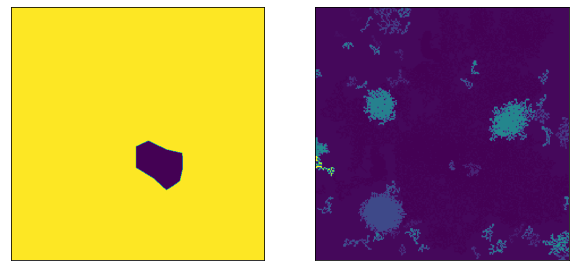

Found 0 points for EISEN/gestalt_shapegen/42.


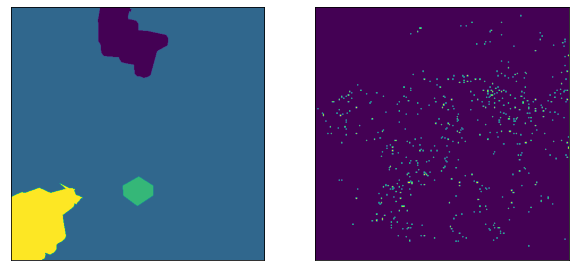

Found 0 points for EISEN/gestalt_shapegen/43.


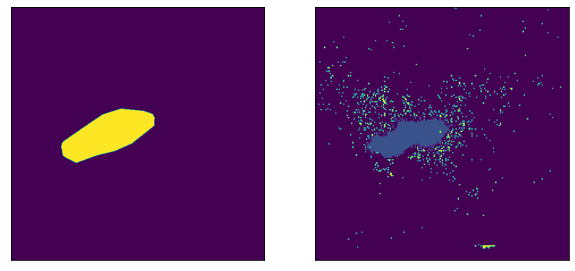

Found 0 points for EISEN/gestalt_shapegen/44.


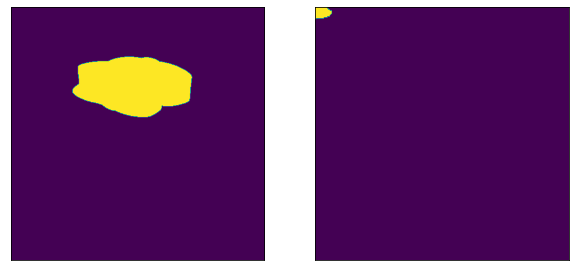

Found 0 points for EISEN/gestalt_shapegen/45.


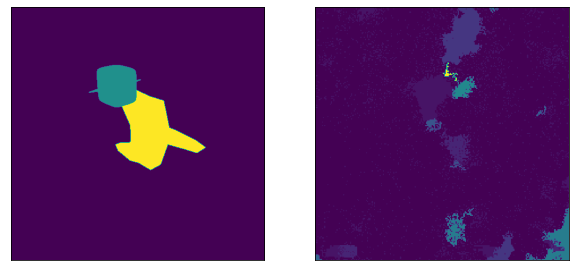

Found 1 points for EISEN/gestalt_shapegen/46.
Found 0 points for EISEN/gestalt_shapegen/47.


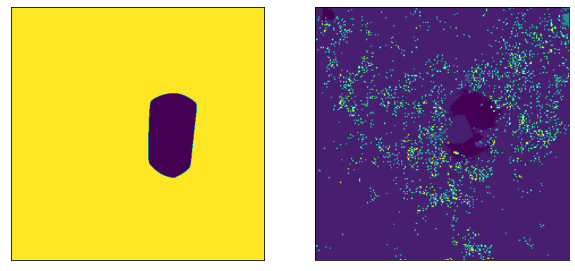

Found 1 points for EISEN/gestalt_shapegen/48.
Found 3 points for EISEN/gestalt_shapegen/49.
Found 2 points for EISEN/gestalt_shapegen/50.
Found 0 points for EISEN/gestalt_shapegen/51.


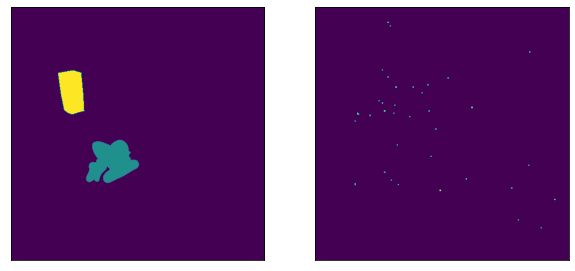

Found 6 points for EISEN/gestalt_shapegen/52.
Found 1 points for EISEN/gestalt_shapegen/53.
Found 0 points for EISEN/gestalt_shapegen/54.


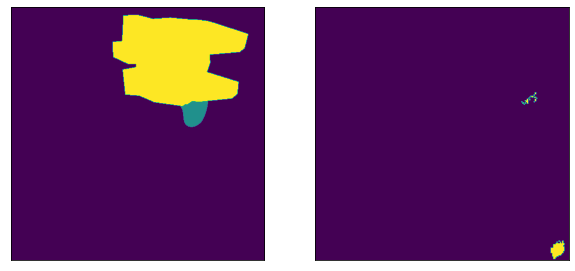

Found 4 points for EISEN/gestalt_shapegen/55.
Found 2 points for EISEN/gestalt_shapegen/56.
Found 1 points for EISEN/gestalt_shapegen/57.
Found 0 points for EISEN/gestalt_shapegen/58.


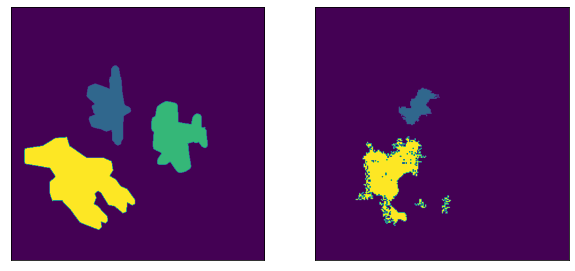

Found 0 points for EISEN/gestalt_shapegen/59.


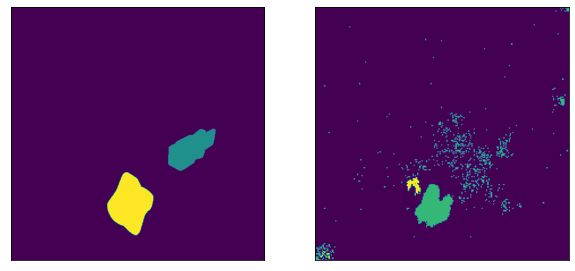

Found 0 points for EISEN/gestalt_shapegen/60.


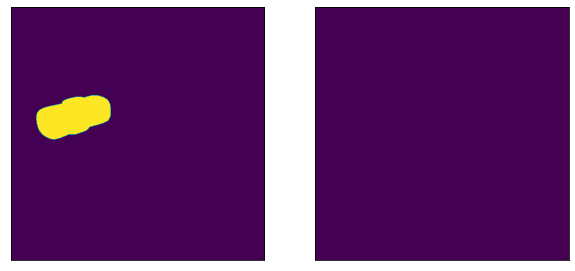

Found 0 points for EISEN/gestalt_shapegen/61.


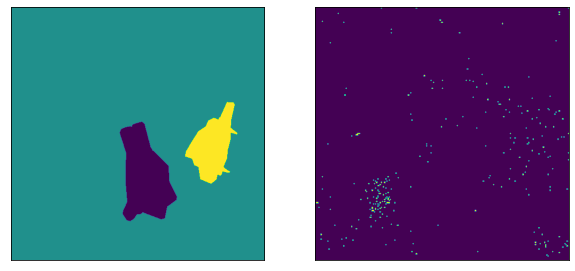

Found 2 points for EISEN/gestalt_shapegen/62.
Found 0 points for EISEN/gestalt_shapegen/63.


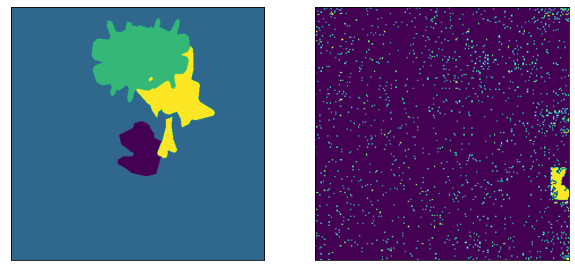

Found 0 points for EISEN/gestalt_shapegen/64.


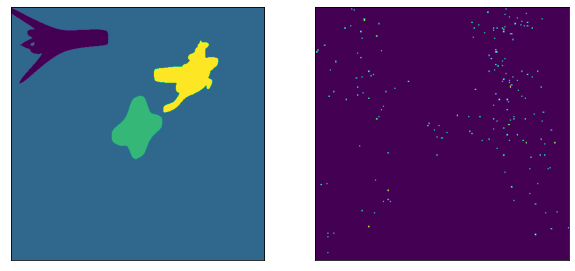

Found 1 points for EISEN/gestalt_shapegen/65.
Found 8 points for EISEN/gestalt_shapegen/66.
Found 0 points for EISEN/gestalt_shapegen/67.


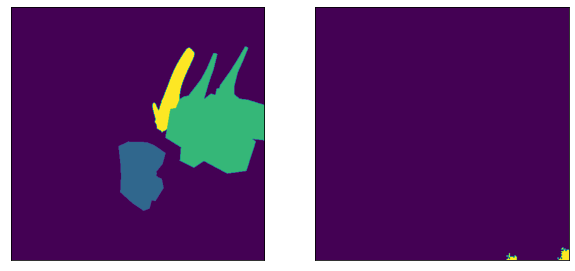

Found 3 points for EISEN/gestalt_shapegen/68.
Found 2 points for EISEN/gestalt_shapegen/69.
Found 3 points for EISEN/gestalt_shapegen/70.
Found 0 points for EISEN/gestalt_shapegen/71.


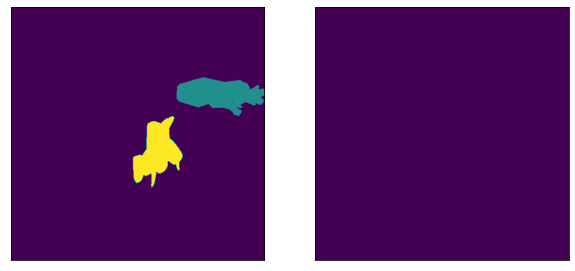

Found 2 points for EISEN/gestalt_shapegen/72.
Found 1 points for EISEN/gestalt_shapegen/73.
Found 0 points for EISEN/gestalt_shapegen/74.


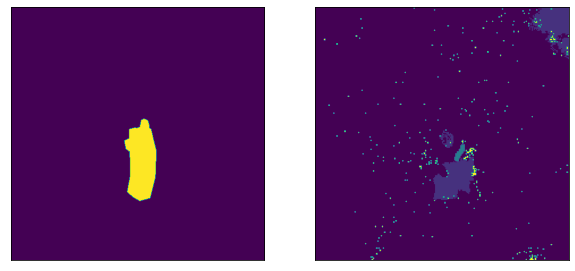

Found 0 points for EISEN/gestalt_shapegen/75.


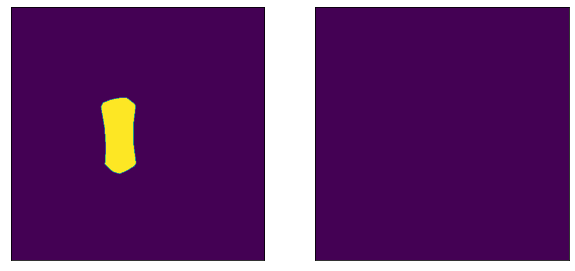

Found 1 points for EISEN/gestalt_shapegen/76.
Found 1 points for EISEN/gestalt_shapegen/77.
Found 1 points for EISEN/gestalt_shapegen/78.
Found 2 points for EISEN/gestalt_shapegen/79.
Found 0 points for EISEN/gestalt_shapegen/80.


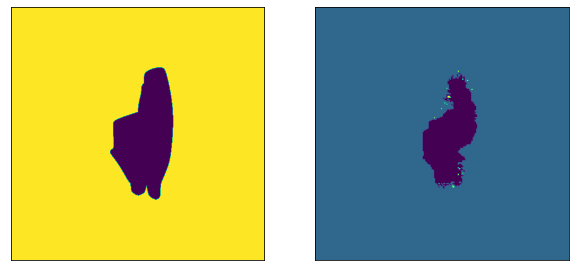

Found 1 points for EISEN/gestalt_shapegen/81.
Found 1 points for EISEN/gestalt_shapegen/82.
Found 0 points for EISEN/gestalt_shapegen/83.


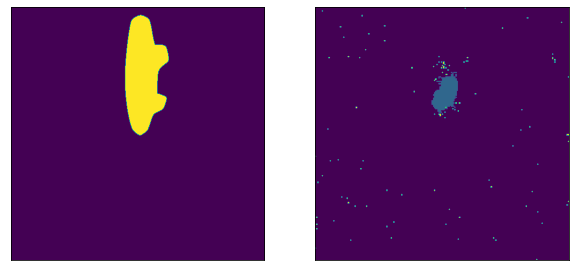

Found 0 points for EISEN/gestalt_shapegen/84.


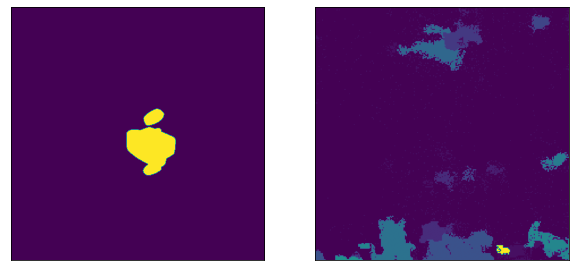

Found 0 points for EISEN/gestalt_shapegen/85.


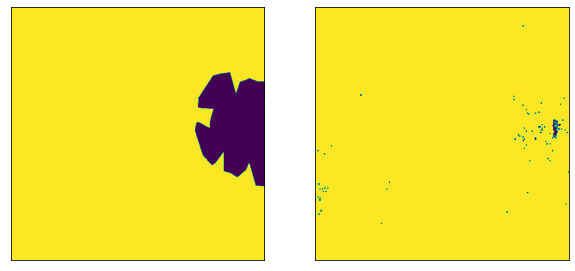

Found 0 points for EISEN/gestalt_shapegen/86.


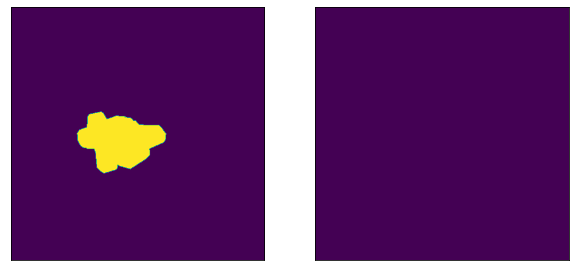

Found 0 points for EISEN/gestalt_shapegen/87.


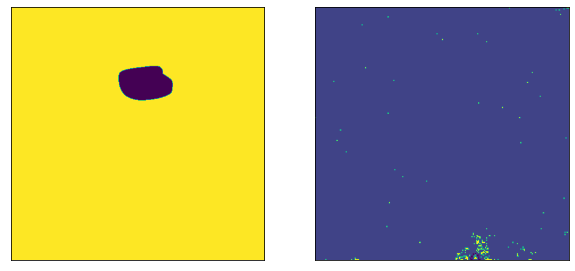

Found 1 points for EISEN/gestalt_shapegen/88.
Found 1 points for EISEN/gestalt_shapegen/89.
Found 1 points for EISEN/gestalt_shapegen/90.
Found 1 points for EISEN/gestalt_shapegen/91.
Found 1 points for EISEN/gestalt_shapegen/92.
Found 4 points for EISEN/gestalt_shapegen/93.
Found 0 points for EISEN/gestalt_shapegen/94.


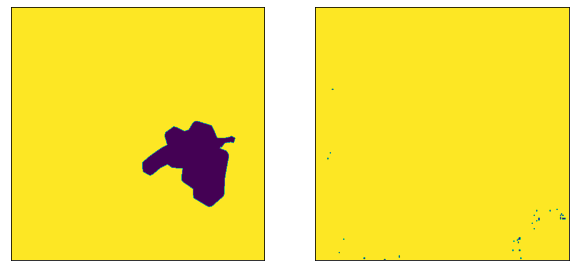

Found 0 points for EISEN/gestalt_shapegen/95.


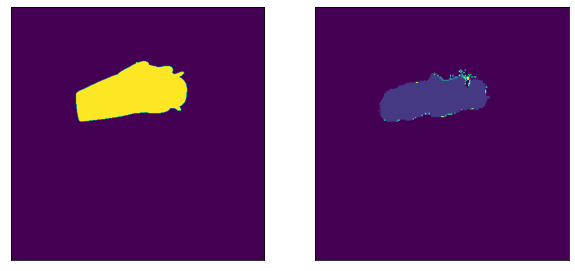

Found 0 points for EISEN/gestalt_shapegen/96.


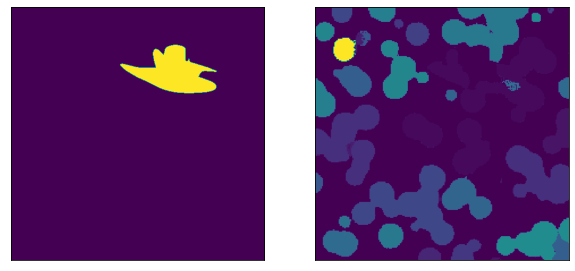

Found 1 points for EISEN/gestalt_shapegen/97.
Found 4 points for EISEN/gestalt_shapegen/98.
Found 0 points for EISEN/gestalt_shapegen/99.


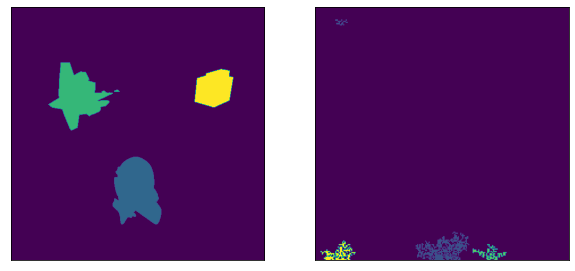

  0%|          | 0/100 [00:00<?, ?it/s]

Found 1 points for EISEN/NSD/0.


<Figure size 720x576 with 0 Axes>

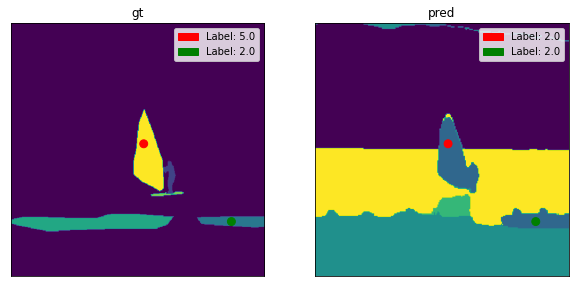

Found 0 points for EISEN/NSD/1.


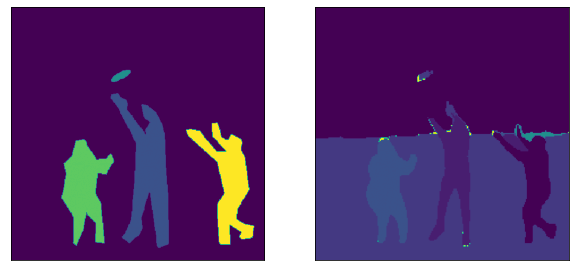

Found 2 points for EISEN/NSD/2.
Found 2 points for EISEN/NSD/3.
Found 1 points for EISEN/NSD/4.
Found 1 points for EISEN/NSD/5.
Found 2 points for EISEN/NSD/6.
Found 3 points for EISEN/NSD/7.
Found 1 points for EISEN/NSD/8.
Found 2 points for EISEN/NSD/9.
Found 0 points for EISEN/NSD/10.


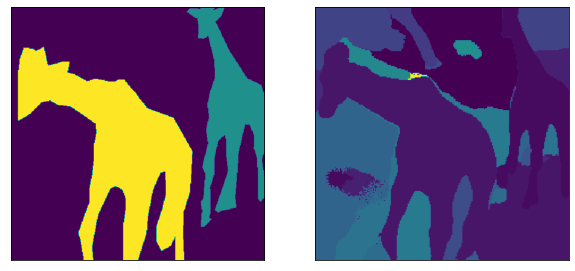

Found 4 points for EISEN/NSD/11.
Found 2 points for EISEN/NSD/12.
Found 2 points for EISEN/NSD/13.
Found 2 points for EISEN/NSD/14.
Found 3 points for EISEN/NSD/15.
Found 3 points for EISEN/NSD/16.
Found 2 points for EISEN/NSD/17.
Found 5 points for EISEN/NSD/18.
Found 1 points for EISEN/NSD/19.
Found 4 points for EISEN/NSD/20.


<Figure size 720x576 with 0 Axes>

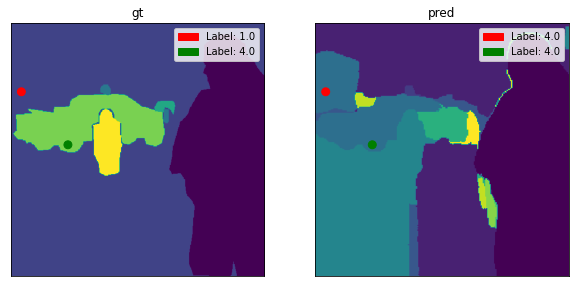

<Figure size 720x576 with 0 Axes>

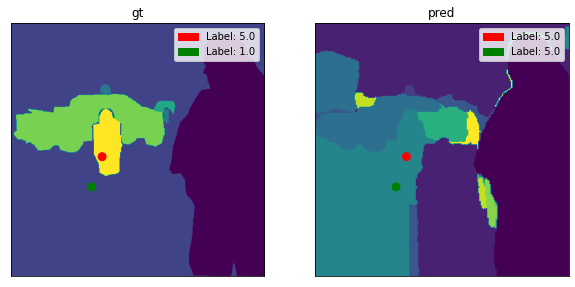

<Figure size 720x576 with 0 Axes>

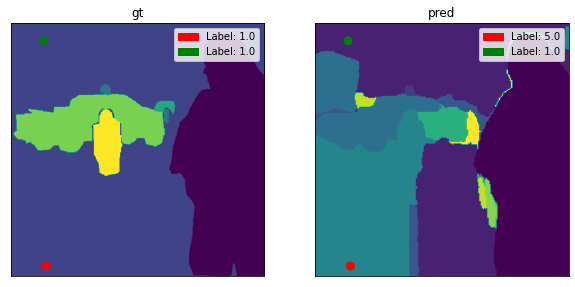

<Figure size 720x576 with 0 Axes>

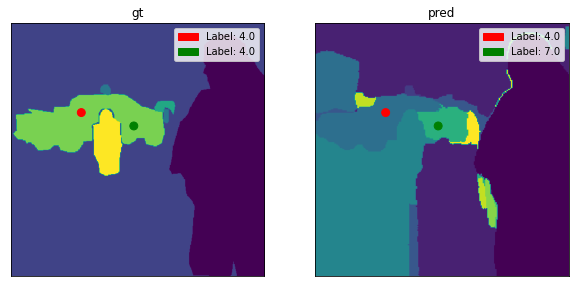

Found 4 points for EISEN/NSD/21.
Found 6 points for EISEN/NSD/22.
Found 3 points for EISEN/NSD/23.
Found 0 points for EISEN/NSD/24.


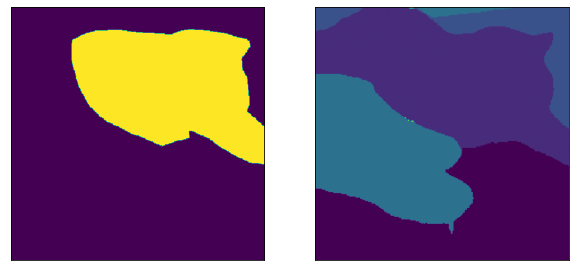

Found 1 points for EISEN/NSD/25.
Found 2 points for EISEN/NSD/26.
Found 4 points for EISEN/NSD/27.
Found 0 points for EISEN/NSD/28.


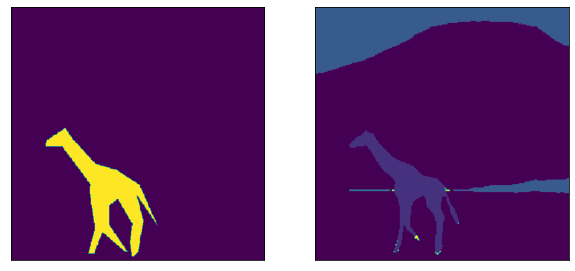

Found 1 points for EISEN/NSD/29.
Found 3 points for EISEN/NSD/30.
Found 0 points for EISEN/NSD/31.


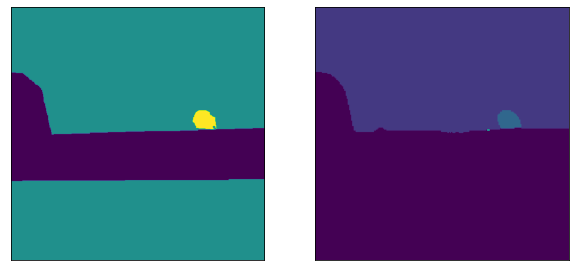

Found 0 points for EISEN/NSD/32.


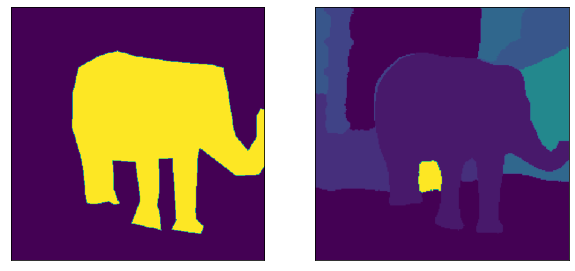

Found 5 points for EISEN/NSD/33.
Found 0 points for EISEN/NSD/34.


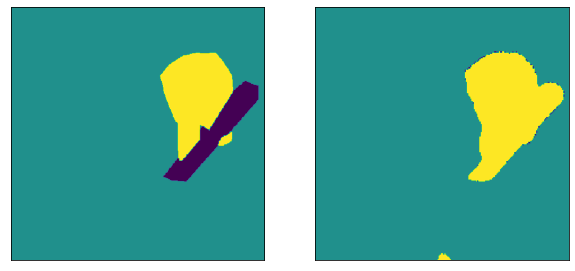

Found 1 points for EISEN/NSD/35.
Found 0 points for EISEN/NSD/36.


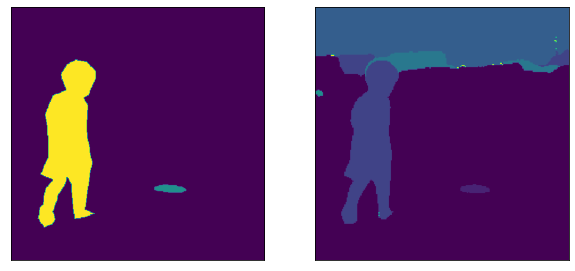

Found 3 points for EISEN/NSD/37.
Found 2 points for EISEN/NSD/38.
Found 1 points for EISEN/NSD/39.
Found 0 points for EISEN/NSD/40.


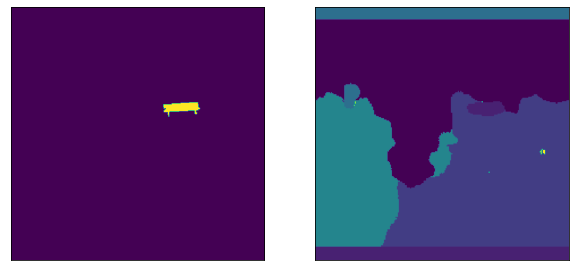

Found 2 points for EISEN/NSD/41.
Found 2 points for EISEN/NSD/42.
Found 3 points for EISEN/NSD/43.
Found 1 points for EISEN/NSD/44.
Found 5 points for EISEN/NSD/45.
Found 1 points for EISEN/NSD/46.
Found 2 points for EISEN/NSD/47.
Found 1 points for EISEN/NSD/48.
Found 4 points for EISEN/NSD/49.
Found 1 points for EISEN/NSD/50.
Found 0 points for EISEN/NSD/51.


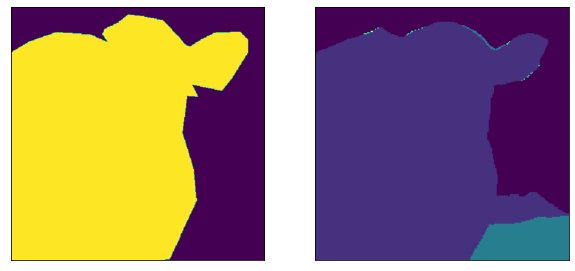

Found 1 points for EISEN/NSD/52.
Found 0 points for EISEN/NSD/53.


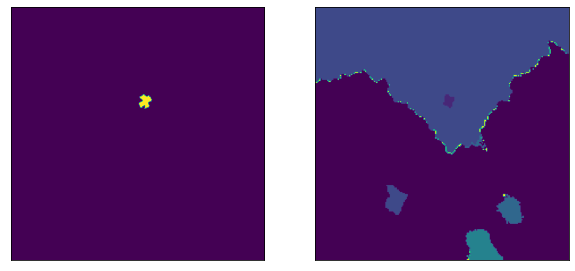

Found 4 points for EISEN/NSD/54.
Found 5 points for EISEN/NSD/55.
Found 11 points for EISEN/NSD/56.
Found 2 points for EISEN/NSD/57.
Found 2 points for EISEN/NSD/58.
Found 3 points for EISEN/NSD/59.
Found 1 points for EISEN/NSD/60.


<Figure size 720x576 with 0 Axes>

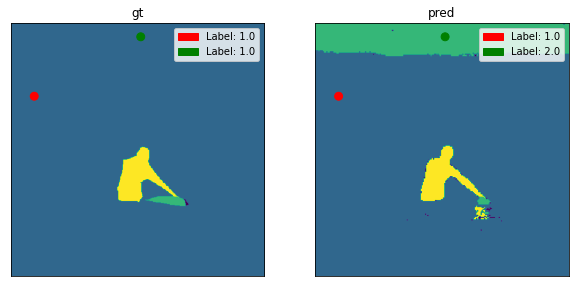

Found 1 points for EISEN/NSD/61.
Found 5 points for EISEN/NSD/62.
Found 0 points for EISEN/NSD/63.


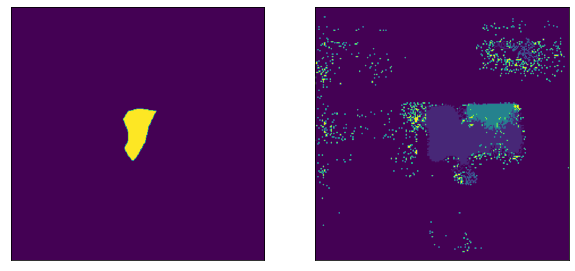

Found 3 points for EISEN/NSD/64.
Found 1 points for EISEN/NSD/65.
Found 2 points for EISEN/NSD/66.
Found 1 points for EISEN/NSD/67.
Found 1 points for EISEN/NSD/68.
Found 2 points for EISEN/NSD/69.
Found 1 points for EISEN/NSD/70.
Found 1 points for EISEN/NSD/71.
Found 2 points for EISEN/NSD/72.
Found 2 points for EISEN/NSD/73.
Found 3 points for EISEN/NSD/74.
Found 6 points for EISEN/NSD/75.
Found 1 points for EISEN/NSD/76.
Found 4 points for EISEN/NSD/77.
Found 7 points for EISEN/NSD/78.
Found 0 points for EISEN/NSD/79.


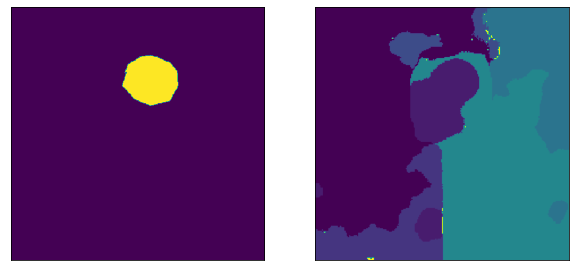

Found 2 points for EISEN/NSD/80.


<Figure size 720x576 with 0 Axes>

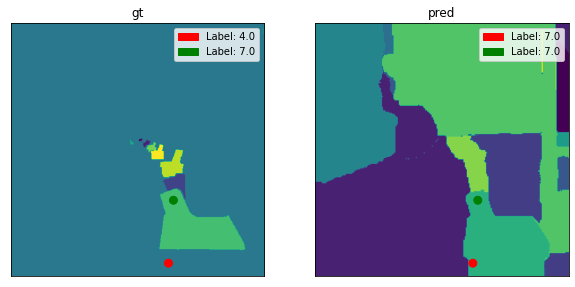

<Figure size 720x576 with 0 Axes>

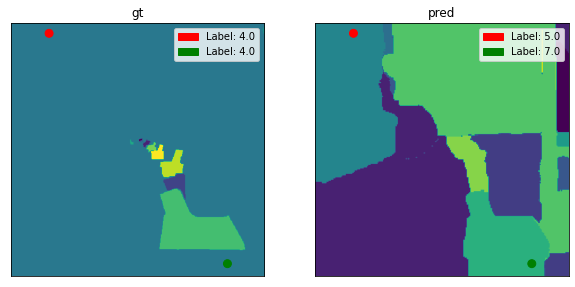

Found 4 points for EISEN/NSD/81.
Found 2 points for EISEN/NSD/82.
Found 0 points for EISEN/NSD/83.


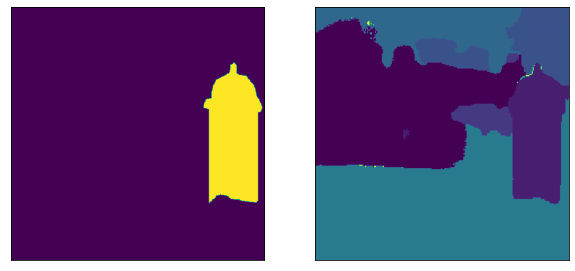

Found 0 points for EISEN/NSD/84.


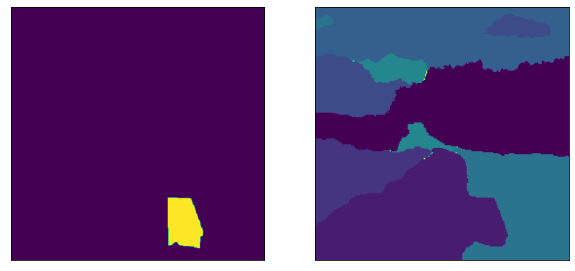

Found 13 points for EISEN/NSD/85.
Found 0 points for EISEN/NSD/86.


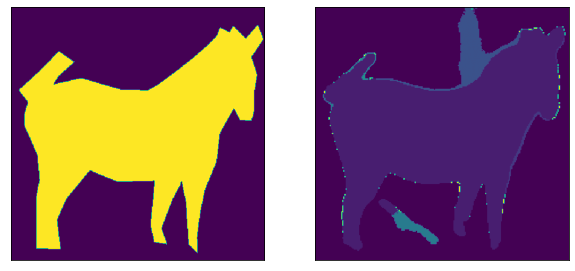

Found 6 points for EISEN/NSD/87.
Found 0 points for EISEN/NSD/88.


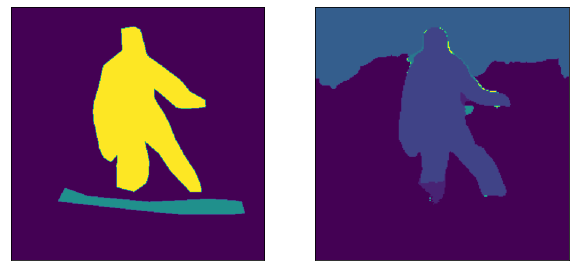

Found 1 points for EISEN/NSD/89.
Found 1 points for EISEN/NSD/90.
Found 2 points for EISEN/NSD/91.
Found 0 points for EISEN/NSD/92.


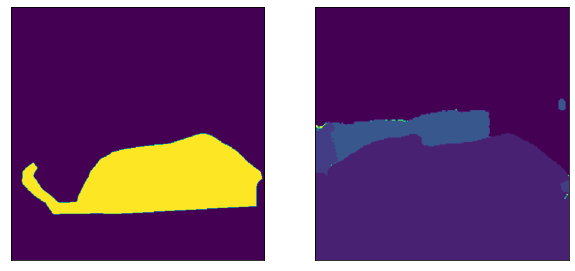

Found 1 points for EISEN/NSD/93.
Found 3 points for EISEN/NSD/94.
Found 4 points for EISEN/NSD/95.
Found 4 points for EISEN/NSD/96.
Found 3 points for EISEN/NSD/97.
Found 1 points for EISEN/NSD/98.
Found 3 points for EISEN/NSD/99.


  0%|          | 0/100 [00:00<?, ?it/s]

Found 3 points for EISEN/hypersim_v3/0.


<Figure size 720x576 with 0 Axes>

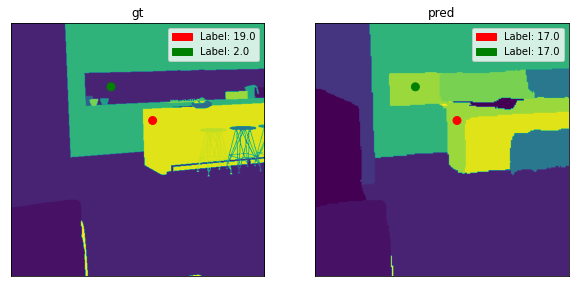

<Figure size 720x576 with 0 Axes>

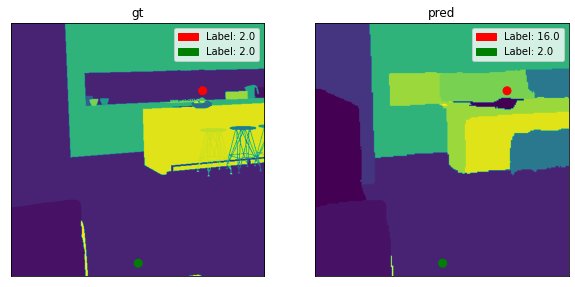

<Figure size 720x576 with 0 Axes>

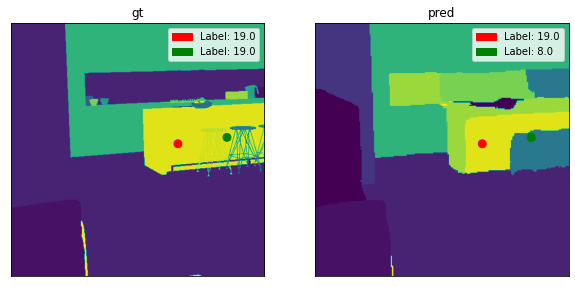

Found 7 points for EISEN/hypersim_v3/1.
Found 6 points for EISEN/hypersim_v3/2.
Found 4 points for EISEN/hypersim_v3/3.
Found 3 points for EISEN/hypersim_v3/4.
Found 3 points for EISEN/hypersim_v3/5.
Found 4 points for EISEN/hypersim_v3/6.
Found 9 points for EISEN/hypersim_v3/7.
Found 6 points for EISEN/hypersim_v3/8.
Found 1 points for EISEN/hypersim_v3/9.
Found 6 points for EISEN/hypersim_v3/10.
Found 0 points for EISEN/hypersim_v3/11.


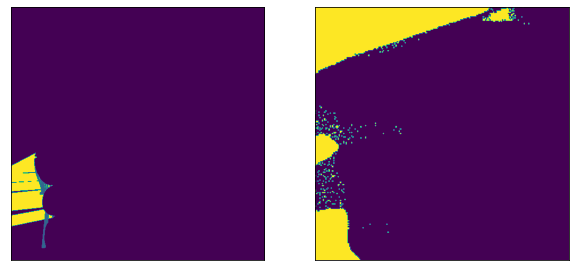

Found 5 points for EISEN/hypersim_v3/12.
Found 2 points for EISEN/hypersim_v3/13.
Found 2 points for EISEN/hypersim_v3/14.
Found 6 points for EISEN/hypersim_v3/15.
Found 2 points for EISEN/hypersim_v3/16.
Found 0 points for EISEN/hypersim_v3/17.


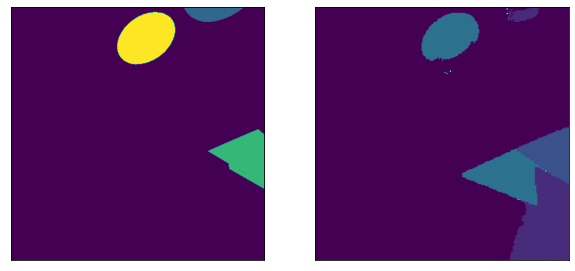

Found 5 points for EISEN/hypersim_v3/18.
Found 9 points for EISEN/hypersim_v3/19.
Found 2 points for EISEN/hypersim_v3/20.


<Figure size 720x576 with 0 Axes>

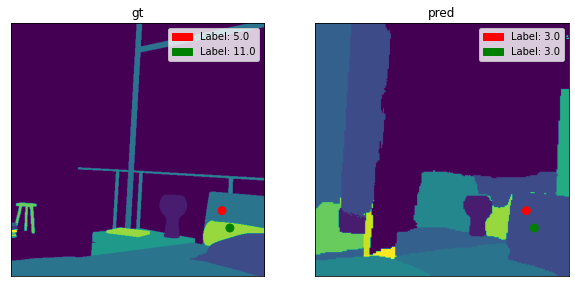

<Figure size 720x576 with 0 Axes>

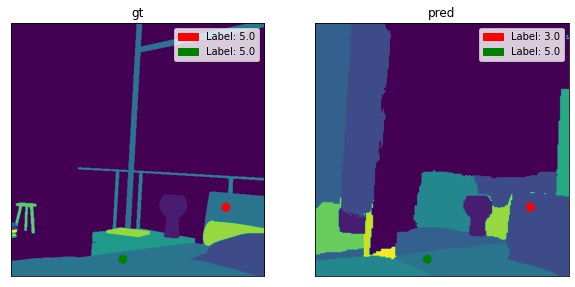

Found 6 points for EISEN/hypersim_v3/21.
Found 4 points for EISEN/hypersim_v3/22.
Found 0 points for EISEN/hypersim_v3/23.


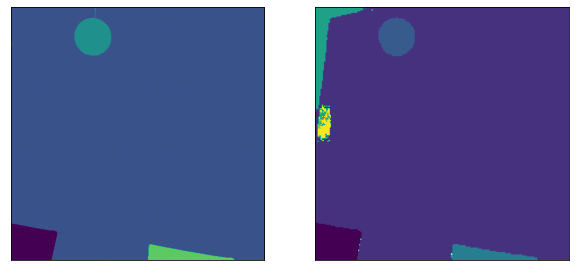

Found 7 points for EISEN/hypersim_v3/24.
Found 6 points for EISEN/hypersim_v3/25.
Found 3 points for EISEN/hypersim_v3/26.
Found 6 points for EISEN/hypersim_v3/27.
Found 4 points for EISEN/hypersim_v3/28.
Found 4 points for EISEN/hypersim_v3/29.
Found 3 points for EISEN/hypersim_v3/30.
Found 1 points for EISEN/hypersim_v3/31.
Found 2 points for EISEN/hypersim_v3/32.
Found 6 points for EISEN/hypersim_v3/33.
Found 6 points for EISEN/hypersim_v3/34.
Found 7 points for EISEN/hypersim_v3/35.
Found 4 points for EISEN/hypersim_v3/36.
Found 1 points for EISEN/hypersim_v3/37.
Found 7 points for EISEN/hypersim_v3/38.
Found 2 points for EISEN/hypersim_v3/39.
Found 6 points for EISEN/hypersim_v3/40.


<Figure size 720x576 with 0 Axes>

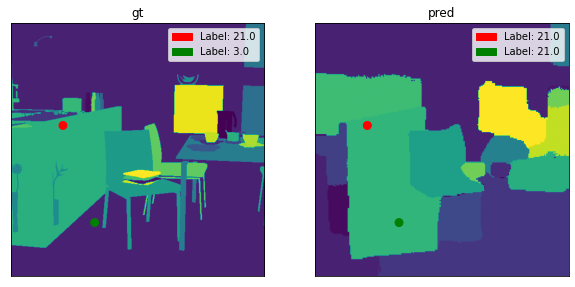

<Figure size 720x576 with 0 Axes>

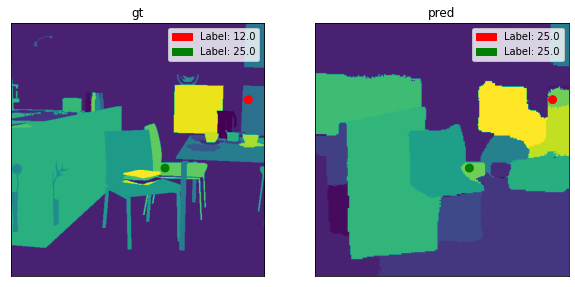

<Figure size 720x576 with 0 Axes>

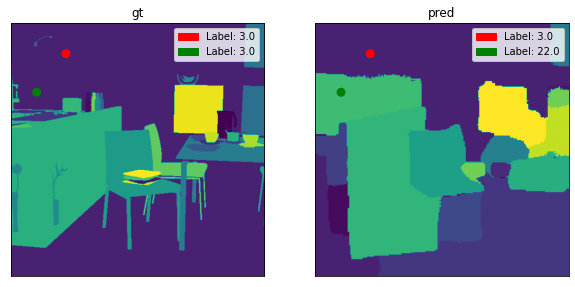

<Figure size 720x576 with 0 Axes>

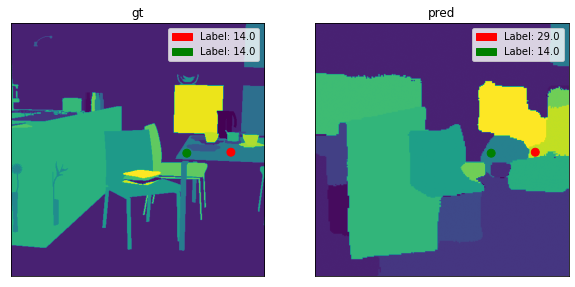

<Figure size 720x576 with 0 Axes>

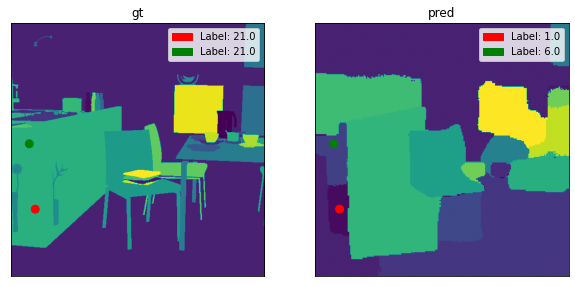

<Figure size 720x576 with 0 Axes>

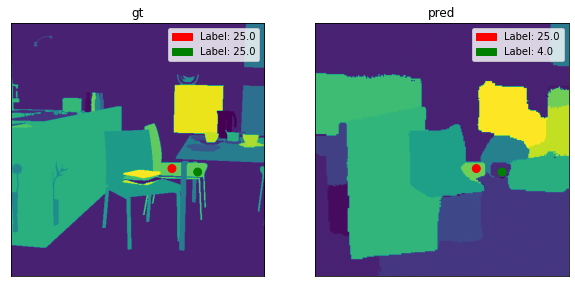

Found 0 points for EISEN/hypersim_v3/41.


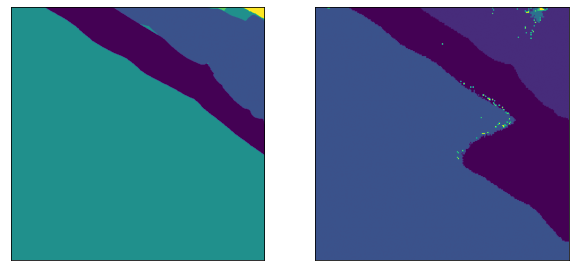

Found 1 points for EISEN/hypersim_v3/42.
Found 1 points for EISEN/hypersim_v3/43.
Found 4 points for EISEN/hypersim_v3/44.
Found 4 points for EISEN/hypersim_v3/45.
Found 2 points for EISEN/hypersim_v3/46.
Found 0 points for EISEN/hypersim_v3/47.


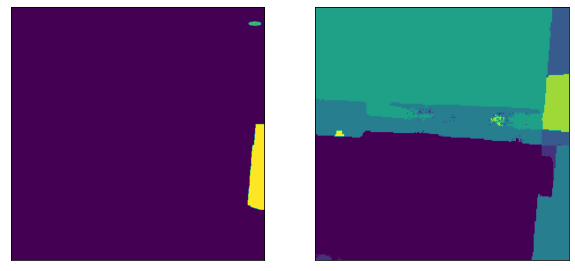

Found 4 points for EISEN/hypersim_v3/48.
Found 14 points for EISEN/hypersim_v3/49.
Found 1 points for EISEN/hypersim_v3/50.
Found 4 points for EISEN/hypersim_v3/51.
Found 7 points for EISEN/hypersim_v3/52.
Found 2 points for EISEN/hypersim_v3/53.
Found 3 points for EISEN/hypersim_v3/54.
Found 8 points for EISEN/hypersim_v3/55.
Found 5 points for EISEN/hypersim_v3/56.
Found 5 points for EISEN/hypersim_v3/57.
Found 6 points for EISEN/hypersim_v3/58.
Found 4 points for EISEN/hypersim_v3/59.
Found 6 points for EISEN/hypersim_v3/60.


<Figure size 720x576 with 0 Axes>

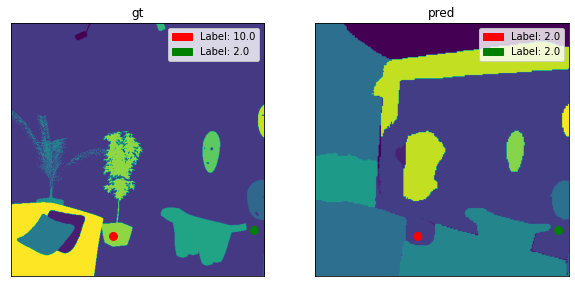

<Figure size 720x576 with 0 Axes>

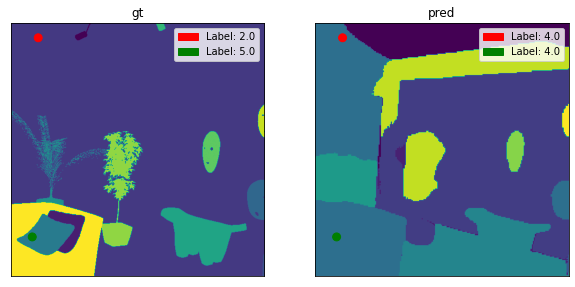

<Figure size 720x576 with 0 Axes>

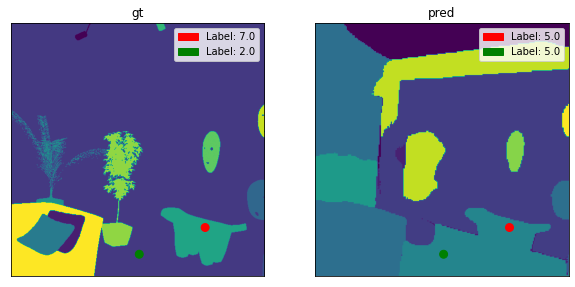

<Figure size 720x576 with 0 Axes>

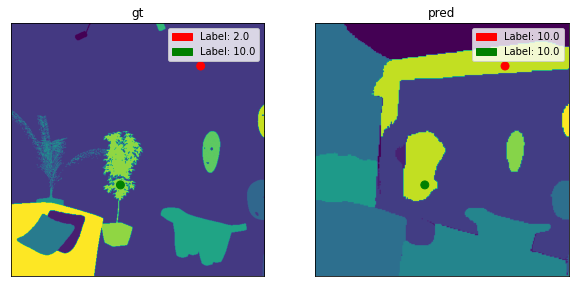

<Figure size 720x576 with 0 Axes>

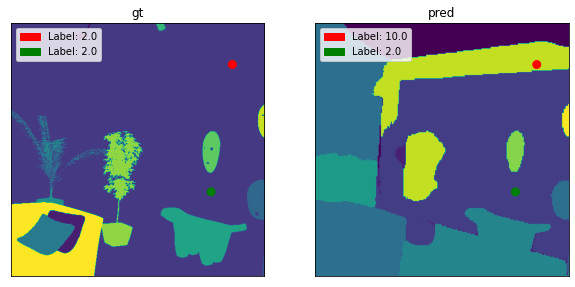

<Figure size 720x576 with 0 Axes>

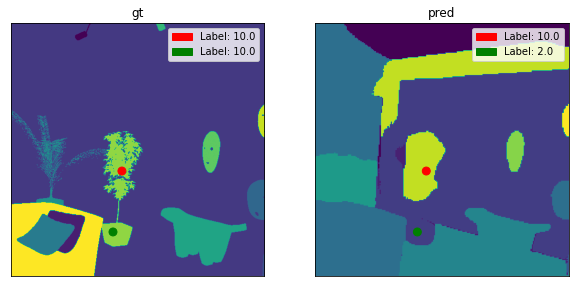

Found 4 points for EISEN/hypersim_v3/61.
Found 5 points for EISEN/hypersim_v3/62.
Found 4 points for EISEN/hypersim_v3/63.
Found 3 points for EISEN/hypersim_v3/64.
Found 5 points for EISEN/hypersim_v3/65.
Found 3 points for EISEN/hypersim_v3/66.
Found 1 points for EISEN/hypersim_v3/67.
Found 7 points for EISEN/hypersim_v3/68.
Found 6 points for EISEN/hypersim_v3/69.
Found 1 points for EISEN/hypersim_v3/70.
Found 2 points for EISEN/hypersim_v3/71.
Found 2 points for EISEN/hypersim_v3/72.
Found 5 points for EISEN/hypersim_v3/73.
Found 3 points for EISEN/hypersim_v3/74.
Found 5 points for EISEN/hypersim_v3/75.
Found 0 points for EISEN/hypersim_v3/76.


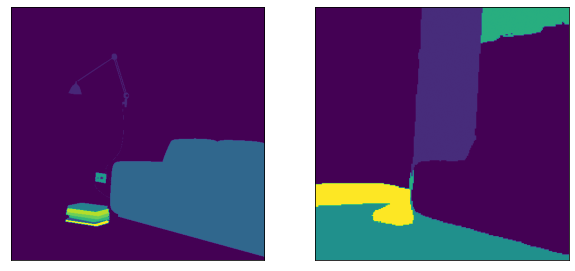

Found 8 points for EISEN/hypersim_v3/77.
Found 2 points for EISEN/hypersim_v3/78.
Found 0 points for EISEN/hypersim_v3/79.


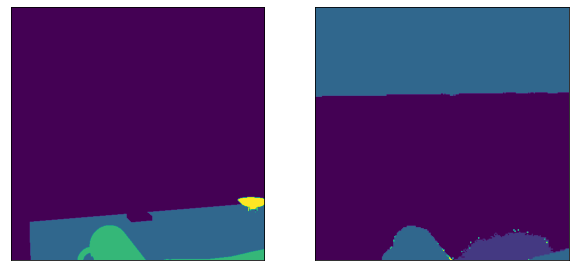

Found 4 points for EISEN/hypersim_v3/80.


<Figure size 720x576 with 0 Axes>

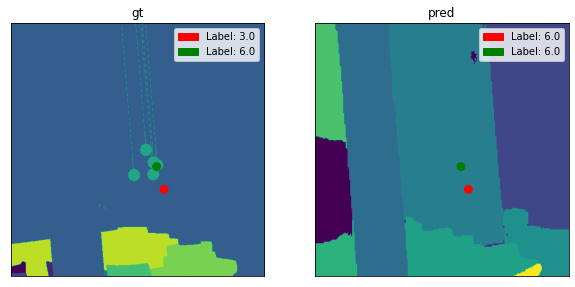

<Figure size 720x576 with 0 Axes>

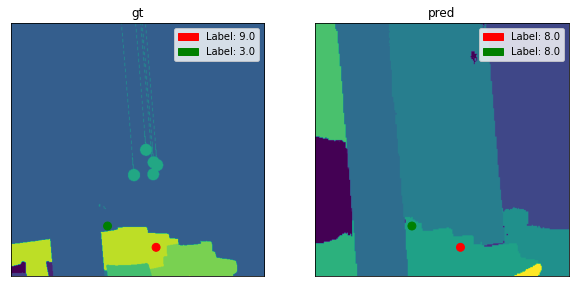

<Figure size 720x576 with 0 Axes>

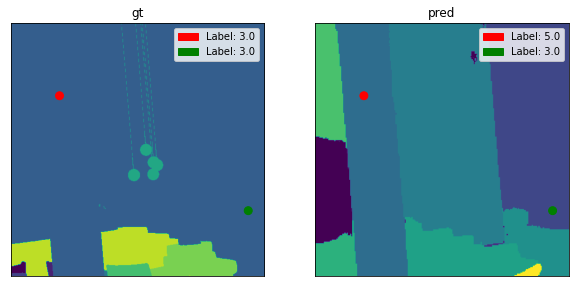

<Figure size 720x576 with 0 Axes>

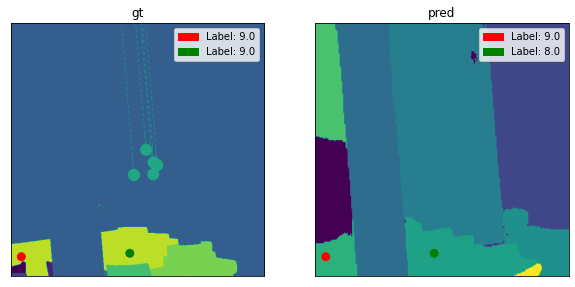

Found 7 points for EISEN/hypersim_v3/81.
Found 4 points for EISEN/hypersim_v3/82.
Found 1 points for EISEN/hypersim_v3/83.
Found 7 points for EISEN/hypersim_v3/84.
Found 5 points for EISEN/hypersim_v3/85.
Found 5 points for EISEN/hypersim_v3/86.
Found 2 points for EISEN/hypersim_v3/87.
Found 3 points for EISEN/hypersim_v3/88.
Found 2 points for EISEN/hypersim_v3/89.
Found 4 points for EISEN/hypersim_v3/90.
Found 7 points for EISEN/hypersim_v3/91.
Found 4 points for EISEN/hypersim_v3/92.
Found 3 points for EISEN/hypersim_v3/93.
Found 2 points for EISEN/hypersim_v3/94.
Found 2 points for EISEN/hypersim_v3/95.
Found 3 points for EISEN/hypersim_v3/96.
Found 5 points for EISEN/hypersim_v3/97.
Found 5 points for EISEN/hypersim_v3/98.
Found 4 points for EISEN/hypersim_v3/99.


  0%|          | 0/100 [00:00<?, ?it/s]

Found 3 points for EISEN/TDW/0.


<Figure size 720x576 with 0 Axes>

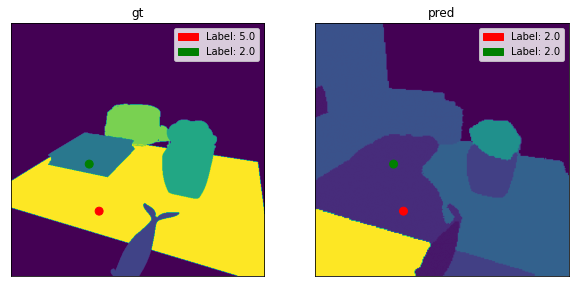

<Figure size 720x576 with 0 Axes>

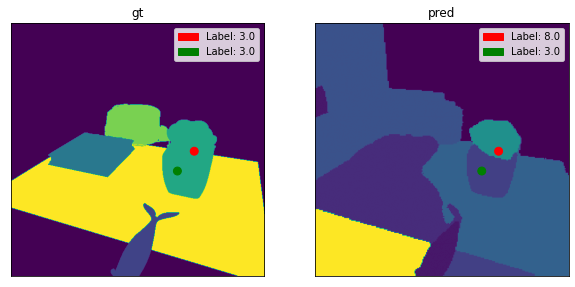

<Figure size 720x576 with 0 Axes>

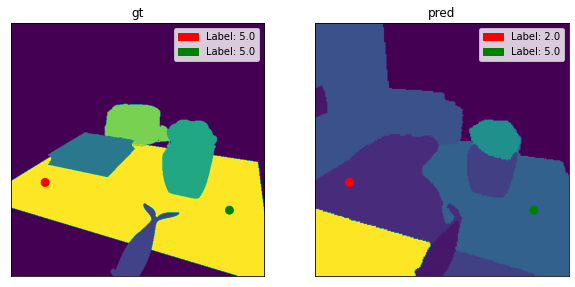

Found 3 points for EISEN/TDW/1.
Found 1 points for EISEN/TDW/2.
Found 1 points for EISEN/TDW/3.
Found 2 points for EISEN/TDW/4.
Found 1 points for EISEN/TDW/5.
Found 2 points for EISEN/TDW/6.
Found 5 points for EISEN/TDW/7.
Found 2 points for EISEN/TDW/8.
Found 0 points for EISEN/TDW/9.


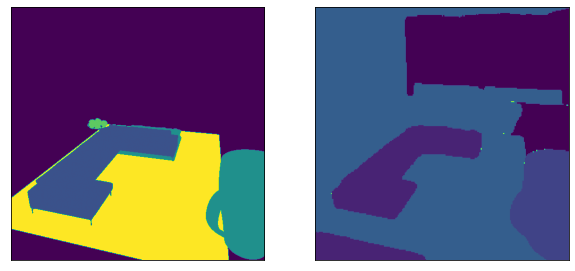

Found 5 points for EISEN/TDW/10.
Found 3 points for EISEN/TDW/11.
Found 2 points for EISEN/TDW/12.
Found 1 points for EISEN/TDW/13.
Found 0 points for EISEN/TDW/14.


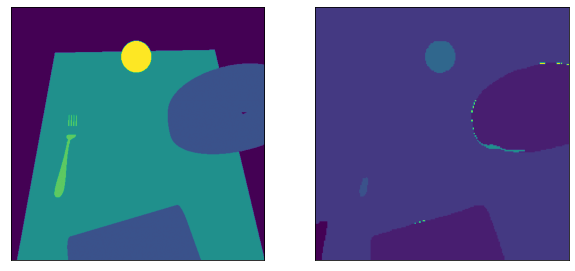

Found 5 points for EISEN/TDW/15.
Found 4 points for EISEN/TDW/16.
Found 2 points for EISEN/TDW/17.
Found 3 points for EISEN/TDW/18.
Found 6 points for EISEN/TDW/19.
Found 4 points for EISEN/TDW/20.


<Figure size 720x576 with 0 Axes>

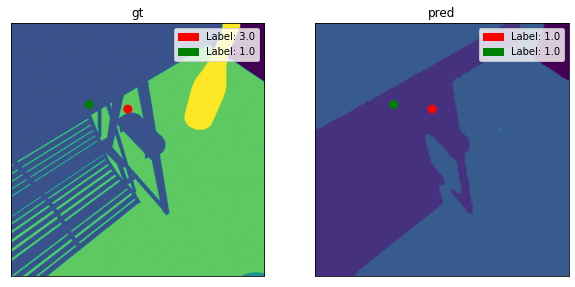

<Figure size 720x576 with 0 Axes>

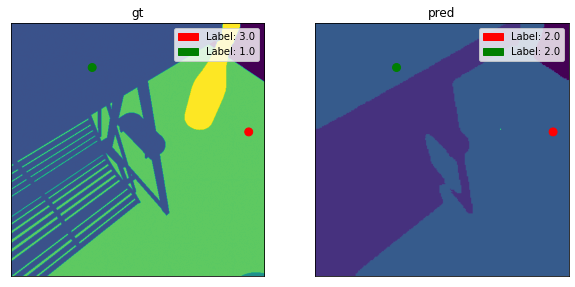

<Figure size 720x576 with 0 Axes>

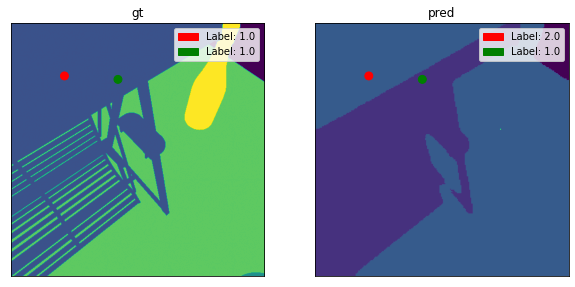

<Figure size 720x576 with 0 Axes>

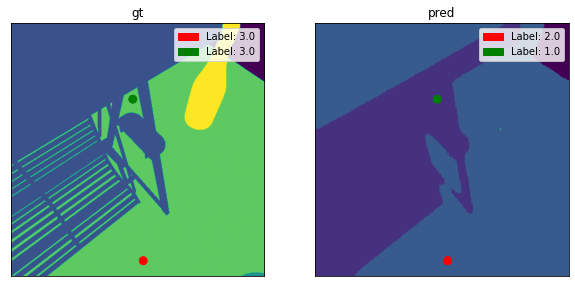

Found 2 points for EISEN/TDW/21.
Found 0 points for EISEN/TDW/22.


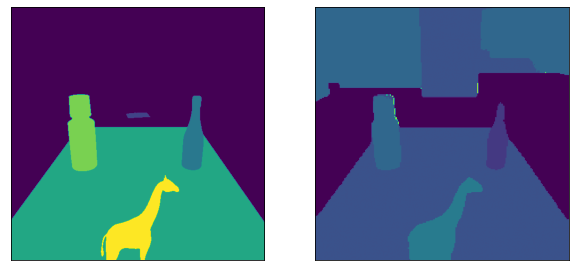

Found 3 points for EISEN/TDW/23.
Found 1 points for EISEN/TDW/24.
Found 4 points for EISEN/TDW/25.
Found 3 points for EISEN/TDW/26.
Found 2 points for EISEN/TDW/27.
Found 5 points for EISEN/TDW/28.
Found 1 points for EISEN/TDW/29.
Found 4 points for EISEN/TDW/30.
Found 2 points for EISEN/TDW/31.
Found 3 points for EISEN/TDW/32.
Found 2 points for EISEN/TDW/33.
Found 1 points for EISEN/TDW/34.
Found 0 points for EISEN/TDW/35.


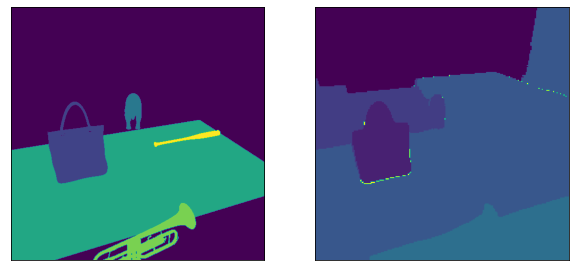

Found 3 points for EISEN/TDW/36.
Found 6 points for EISEN/TDW/37.
Found 3 points for EISEN/TDW/38.
Found 3 points for EISEN/TDW/39.
Found 1 points for EISEN/TDW/40.


<Figure size 720x576 with 0 Axes>

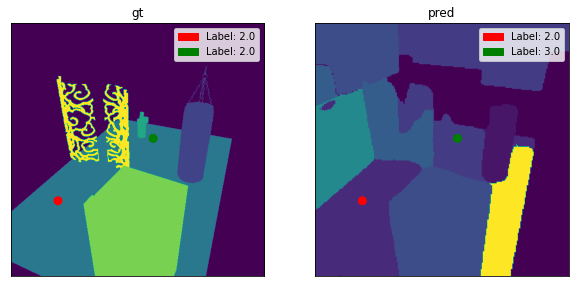

Found 2 points for EISEN/TDW/41.
Found 0 points for EISEN/TDW/42.


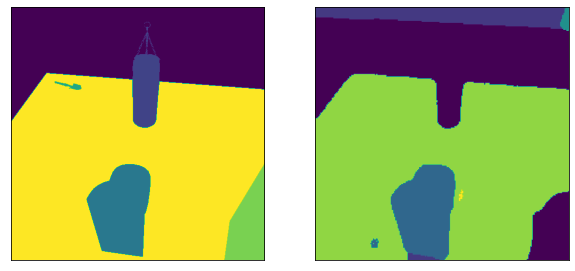

Found 3 points for EISEN/TDW/43.
Found 5 points for EISEN/TDW/44.
Found 6 points for EISEN/TDW/45.
Found 4 points for EISEN/TDW/46.
Found 2 points for EISEN/TDW/47.
Found 1 points for EISEN/TDW/48.
Found 4 points for EISEN/TDW/49.
Found 1 points for EISEN/TDW/50.
Found 4 points for EISEN/TDW/51.
Found 0 points for EISEN/TDW/52.


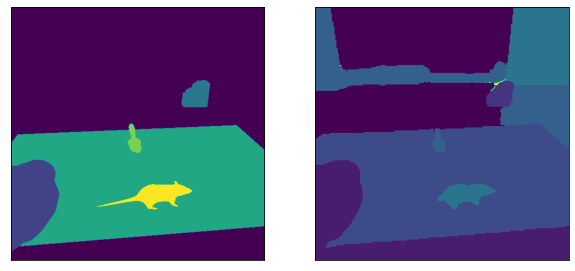

Found 0 points for EISEN/TDW/53.


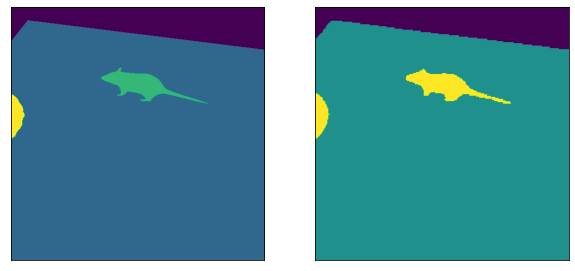

Found 1 points for EISEN/TDW/54.
Found 2 points for EISEN/TDW/55.
Found 2 points for EISEN/TDW/56.
Found 1 points for EISEN/TDW/57.
Found 1 points for EISEN/TDW/58.
Found 0 points for EISEN/TDW/59.


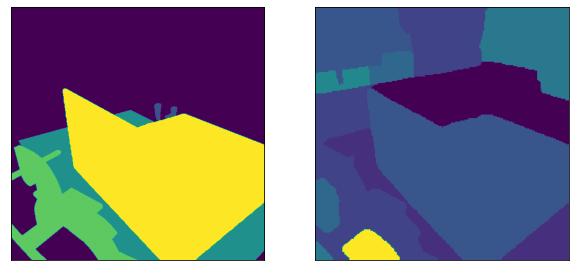

Found 1 points for EISEN/TDW/60.


<Figure size 720x576 with 0 Axes>

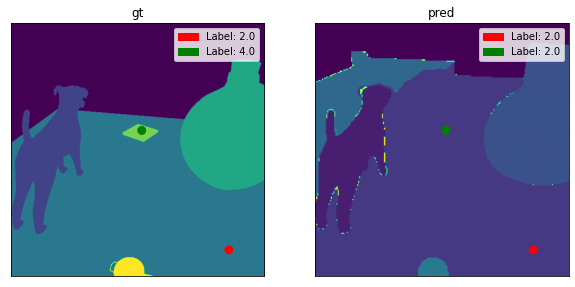

Found 3 points for EISEN/TDW/61.
Found 3 points for EISEN/TDW/62.
Found 1 points for EISEN/TDW/63.
Found 1 points for EISEN/TDW/64.
Found 4 points for EISEN/TDW/65.
Found 2 points for EISEN/TDW/66.
Found 1 points for EISEN/TDW/67.
Found 5 points for EISEN/TDW/68.
Found 1 points for EISEN/TDW/69.
Found 4 points for EISEN/TDW/70.
Found 2 points for EISEN/TDW/71.
Found 0 points for EISEN/TDW/72.


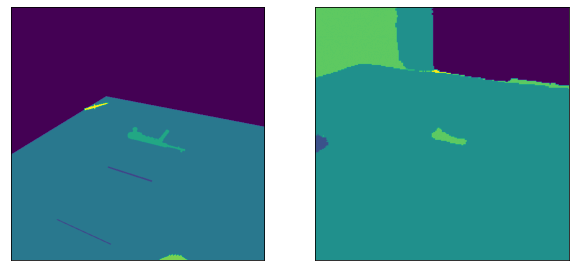

Found 1 points for EISEN/TDW/73.
Found 3 points for EISEN/TDW/74.
Found 3 points for EISEN/TDW/75.
Found 1 points for EISEN/TDW/76.
Found 1 points for EISEN/TDW/77.
Found 1 points for EISEN/TDW/78.
Found 1 points for EISEN/TDW/79.
Found 4 points for EISEN/TDW/80.


<Figure size 720x576 with 0 Axes>

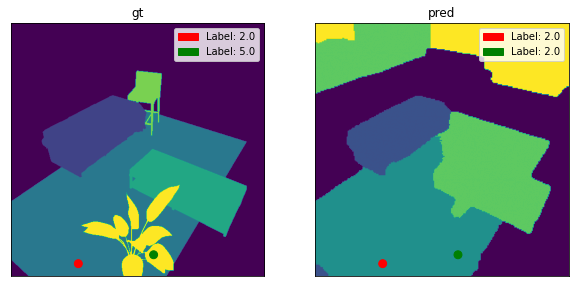

<Figure size 720x576 with 0 Axes>

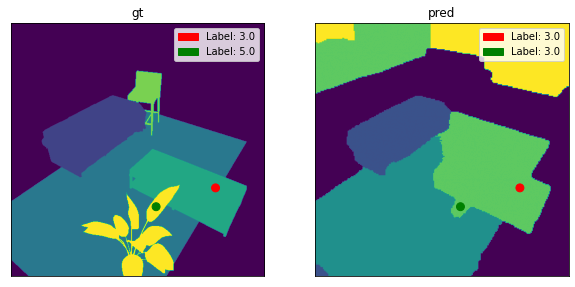

<Figure size 720x576 with 0 Axes>

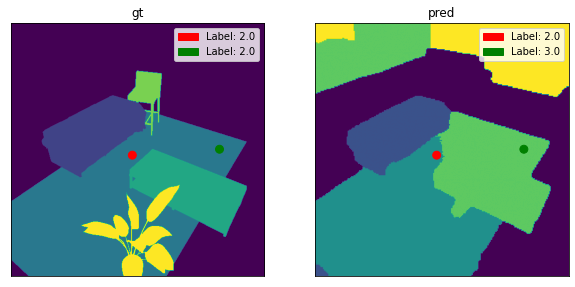

<Figure size 720x576 with 0 Axes>

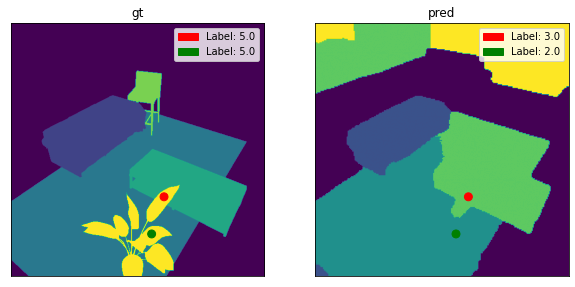

Found 1 points for EISEN/TDW/81.
Found 0 points for EISEN/TDW/82.


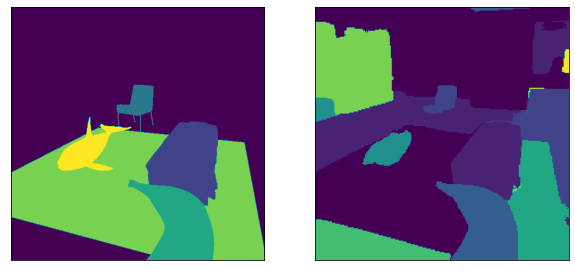

Found 2 points for EISEN/TDW/83.
Found 3 points for EISEN/TDW/84.
Found 1 points for EISEN/TDW/85.
Found 5 points for EISEN/TDW/86.
Found 4 points for EISEN/TDW/87.
Found 3 points for EISEN/TDW/88.
Found 7 points for EISEN/TDW/89.
Found 3 points for EISEN/TDW/90.
Found 1 points for EISEN/TDW/91.
Found 0 points for EISEN/TDW/92.


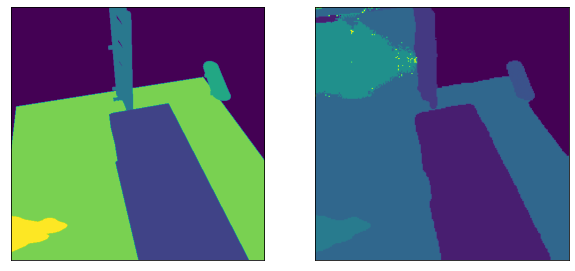

Found 2 points for EISEN/TDW/93.
Found 1 points for EISEN/TDW/94.
Found 0 points for EISEN/TDW/95.


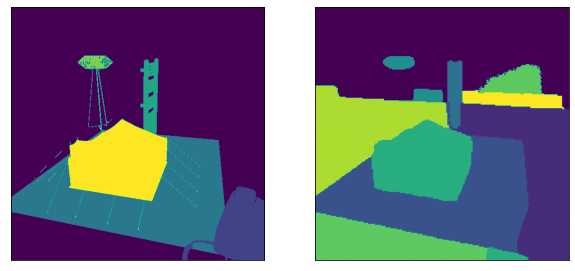

Found 1 points for EISEN/TDW/96.
Found 3 points for EISEN/TDW/97.
Found 0 points for EISEN/TDW/98.


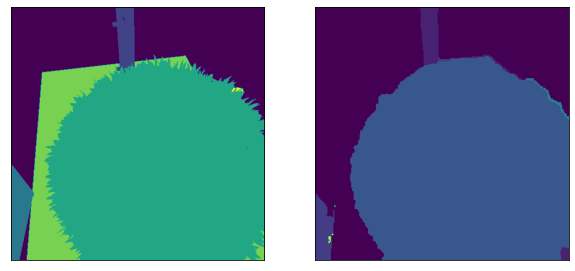

Found 2 points for EISEN/TDW/99.


  0%|          | 0/100 [00:00<?, ?it/s]

Found 2 points for DPT/gestalt_shapegen/0.


<Figure size 720x576 with 0 Axes>

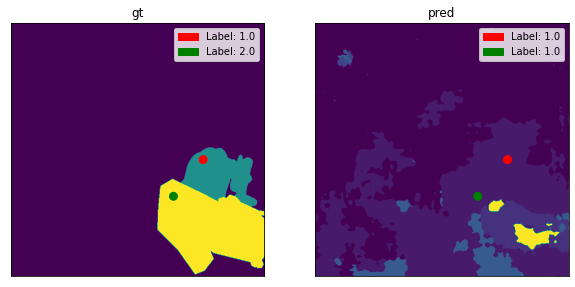

<Figure size 720x576 with 0 Axes>

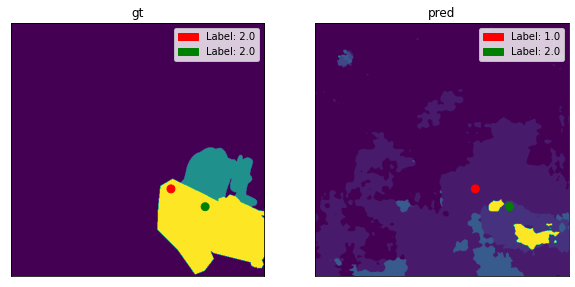

Found 1 points for DPT/gestalt_shapegen/1.
Found 0 points for DPT/gestalt_shapegen/2.


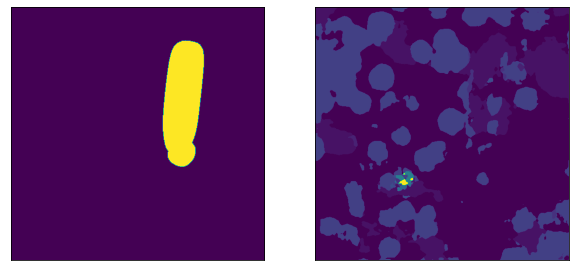

Found 1 points for DPT/gestalt_shapegen/3.
Found 1 points for DPT/gestalt_shapegen/4.
Found 3 points for DPT/gestalt_shapegen/5.
Found 0 points for DPT/gestalt_shapegen/6.


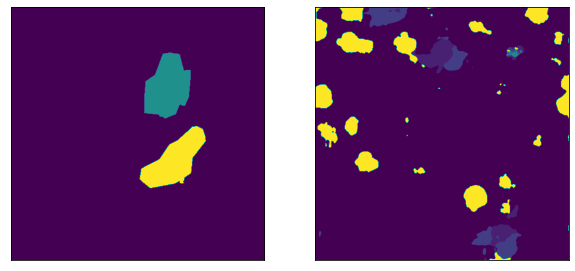

Found 5 points for DPT/gestalt_shapegen/7.
Found 0 points for DPT/gestalt_shapegen/8.


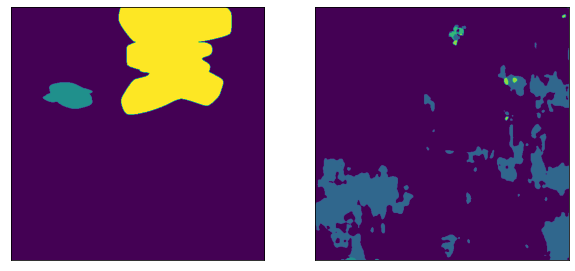

Found 1 points for DPT/gestalt_shapegen/9.
Found 0 points for DPT/gestalt_shapegen/10.


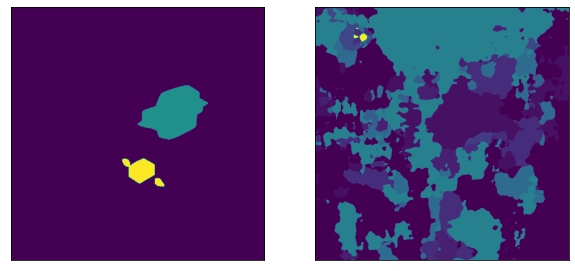

Found 1 points for DPT/gestalt_shapegen/11.
Found 0 points for DPT/gestalt_shapegen/12.


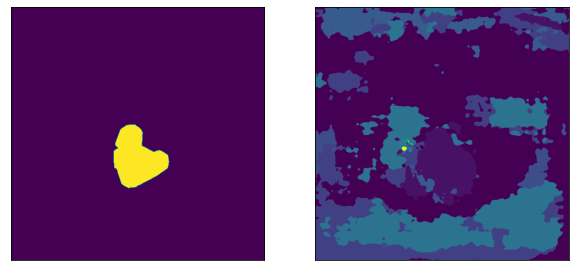

Found 4 points for DPT/gestalt_shapegen/13.
Found 2 points for DPT/gestalt_shapegen/14.
Found 0 points for DPT/gestalt_shapegen/15.


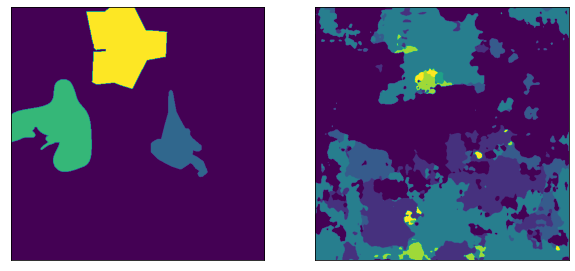

Found 2 points for DPT/gestalt_shapegen/16.
Found 0 points for DPT/gestalt_shapegen/17.


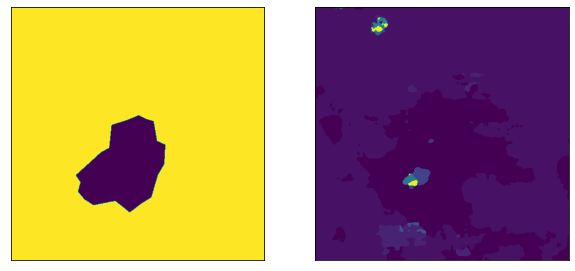

Found 4 points for DPT/gestalt_shapegen/18.
Found 4 points for DPT/gestalt_shapegen/19.
Found 1 points for DPT/gestalt_shapegen/20.


<Figure size 720x576 with 0 Axes>

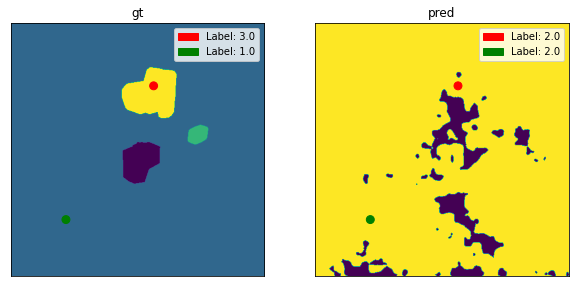

Found 0 points for DPT/gestalt_shapegen/21.


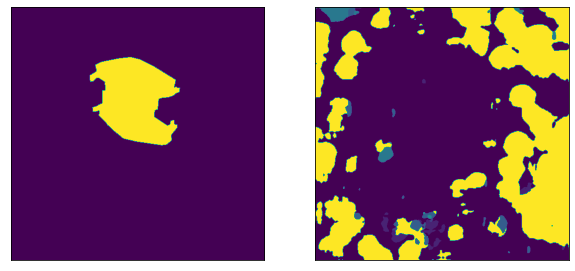

Found 0 points for DPT/gestalt_shapegen/22.


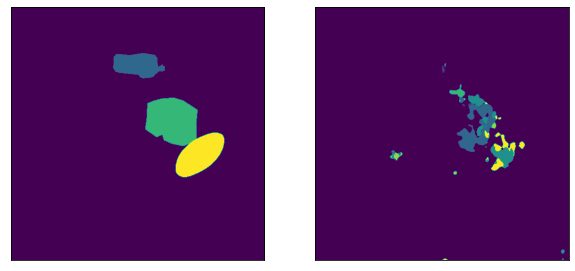

Found 0 points for DPT/gestalt_shapegen/23.


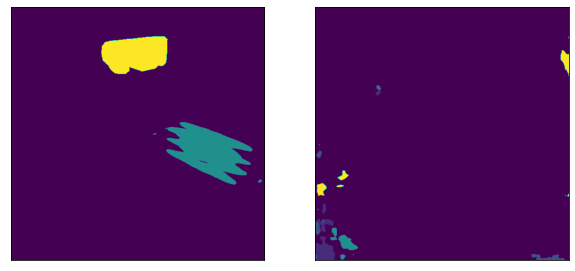

Found 6 points for DPT/gestalt_shapegen/24.
Found 1 points for DPT/gestalt_shapegen/25.
Found 1 points for DPT/gestalt_shapegen/26.
Found 1 points for DPT/gestalt_shapegen/27.
Found 1 points for DPT/gestalt_shapegen/28.
Found 0 points for DPT/gestalt_shapegen/29.


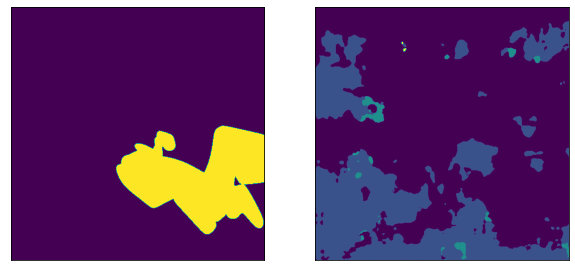

Found 1 points for DPT/gestalt_shapegen/30.
Found 4 points for DPT/gestalt_shapegen/31.
Found 0 points for DPT/gestalt_shapegen/32.


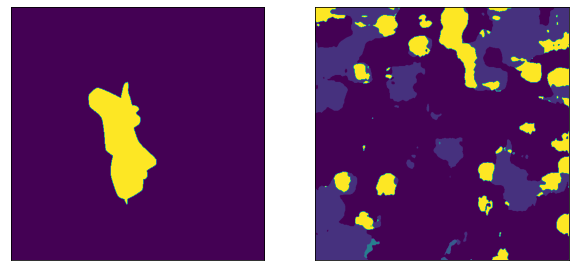

Found 4 points for DPT/gestalt_shapegen/33.
Found 1 points for DPT/gestalt_shapegen/34.
Found 0 points for DPT/gestalt_shapegen/35.


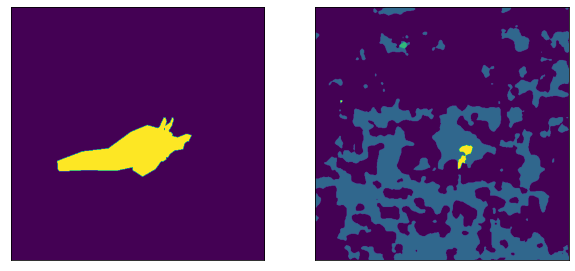

Found 0 points for DPT/gestalt_shapegen/36.


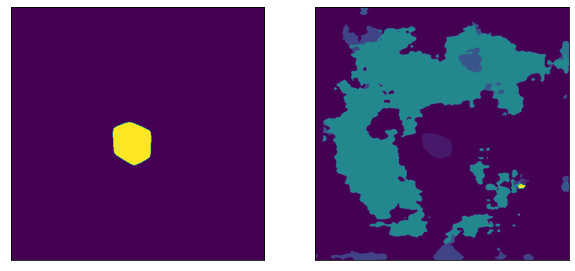

Found 0 points for DPT/gestalt_shapegen/37.


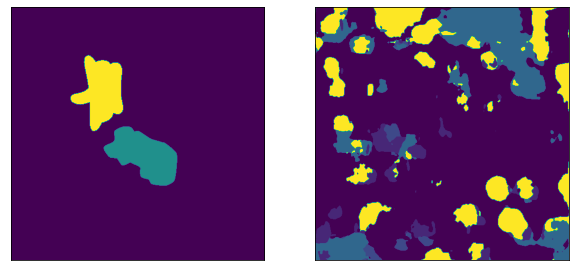

Found 1 points for DPT/gestalt_shapegen/38.
Found 1 points for DPT/gestalt_shapegen/39.
Found 4 points for DPT/gestalt_shapegen/40.


<Figure size 720x576 with 0 Axes>

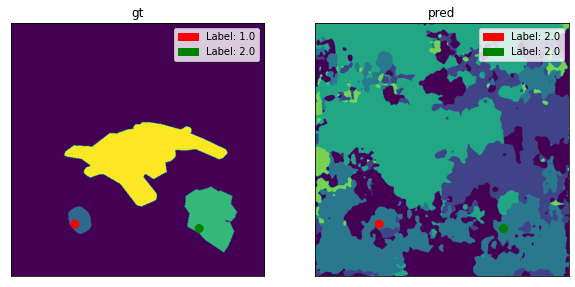

<Figure size 720x576 with 0 Axes>

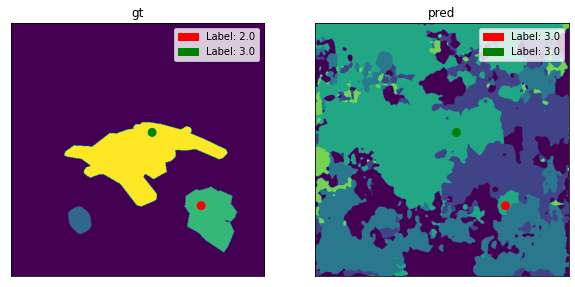

<Figure size 720x576 with 0 Axes>

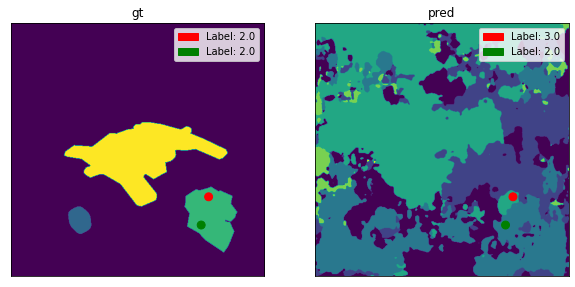

<Figure size 720x576 with 0 Axes>

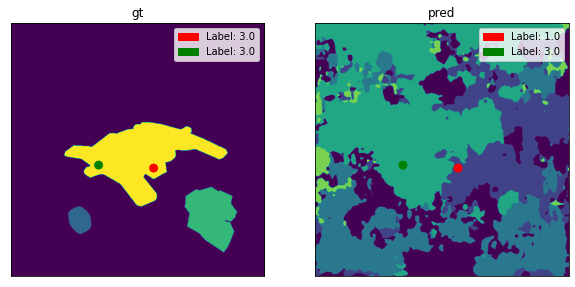

Found 0 points for DPT/gestalt_shapegen/41.


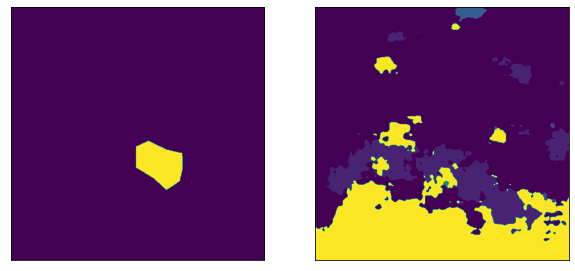

Found 2 points for DPT/gestalt_shapegen/42.
Found 0 points for DPT/gestalt_shapegen/43.


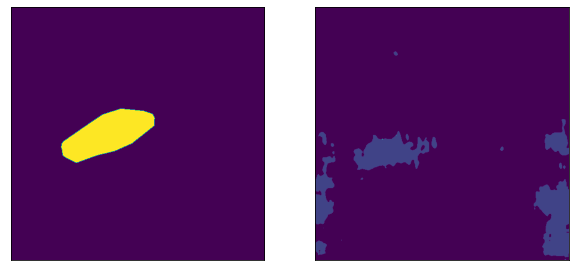

Found 0 points for DPT/gestalt_shapegen/44.


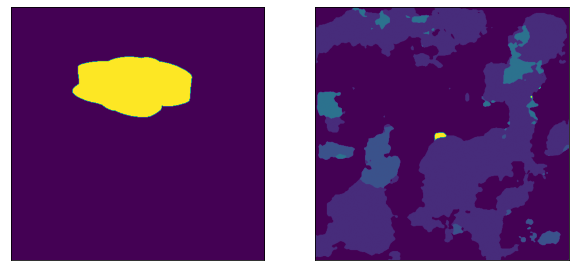

Found 1 points for DPT/gestalt_shapegen/45.
Found 1 points for DPT/gestalt_shapegen/46.
Found 0 points for DPT/gestalt_shapegen/47.


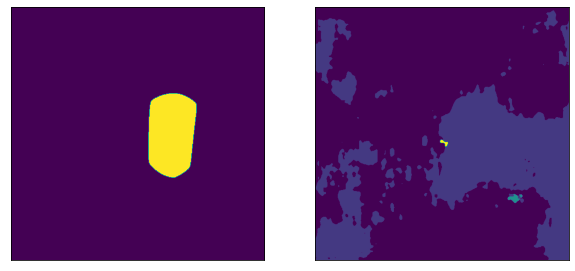

Found 0 points for DPT/gestalt_shapegen/48.


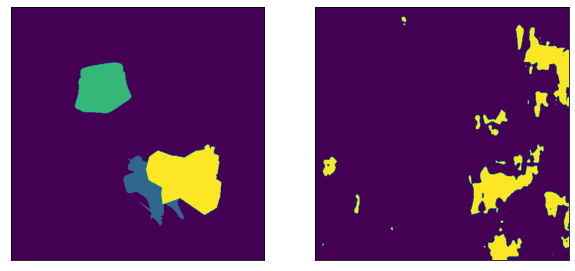

Found 1 points for DPT/gestalt_shapegen/49.
Found 0 points for DPT/gestalt_shapegen/50.


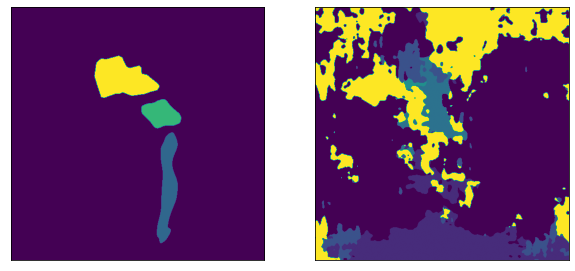

Found 1 points for DPT/gestalt_shapegen/51.
Found 0 points for DPT/gestalt_shapegen/52.


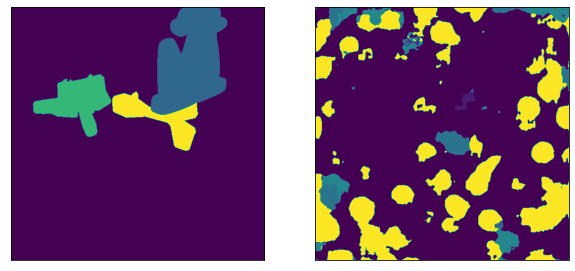

Found 2 points for DPT/gestalt_shapegen/53.
Found 1 points for DPT/gestalt_shapegen/54.
Found 2 points for DPT/gestalt_shapegen/55.
Found 4 points for DPT/gestalt_shapegen/56.
Found 1 points for DPT/gestalt_shapegen/57.
Found 1 points for DPT/gestalt_shapegen/58.
Found 1 points for DPT/gestalt_shapegen/59.
Found 0 points for DPT/gestalt_shapegen/60.


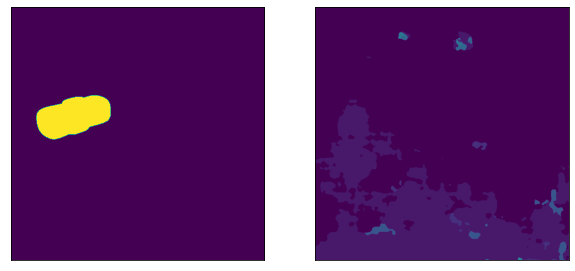

Found 1 points for DPT/gestalt_shapegen/61.
Found 1 points for DPT/gestalt_shapegen/62.
Found 4 points for DPT/gestalt_shapegen/63.
Found 2 points for DPT/gestalt_shapegen/64.
Found 1 points for DPT/gestalt_shapegen/65.
Found 5 points for DPT/gestalt_shapegen/66.
Found 2 points for DPT/gestalt_shapegen/67.
Found 1 points for DPT/gestalt_shapegen/68.
Found 2 points for DPT/gestalt_shapegen/69.
Found 2 points for DPT/gestalt_shapegen/70.
Found 0 points for DPT/gestalt_shapegen/71.


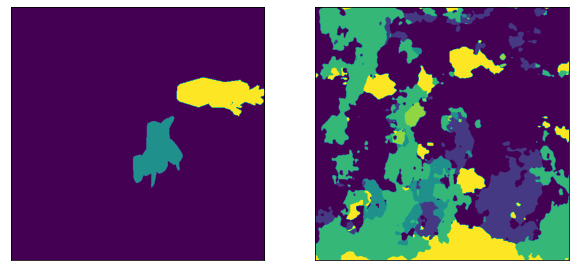

Found 0 points for DPT/gestalt_shapegen/72.


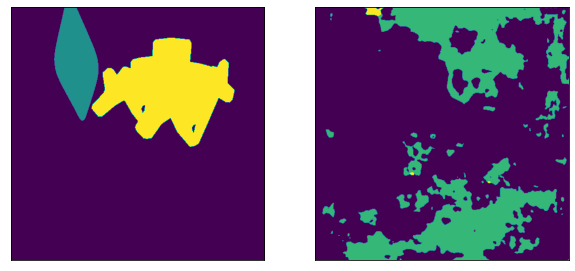

Found 1 points for DPT/gestalt_shapegen/73.
Found 1 points for DPT/gestalt_shapegen/74.
Found 0 points for DPT/gestalt_shapegen/75.


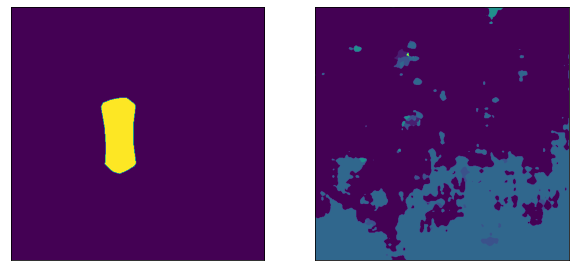

Found 4 points for DPT/gestalt_shapegen/76.
Found 1 points for DPT/gestalt_shapegen/77.
Found 4 points for DPT/gestalt_shapegen/78.
Found 2 points for DPT/gestalt_shapegen/79.
Found 1 points for DPT/gestalt_shapegen/80.


<Figure size 720x576 with 0 Axes>

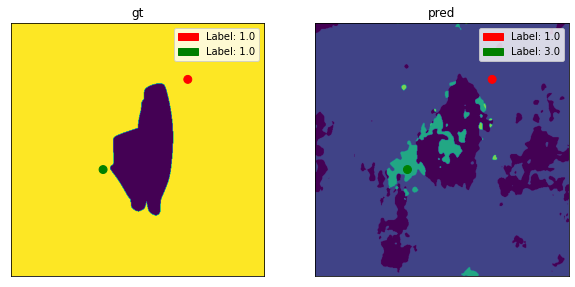

Found 2 points for DPT/gestalt_shapegen/81.
Found 4 points for DPT/gestalt_shapegen/82.
Found 0 points for DPT/gestalt_shapegen/83.


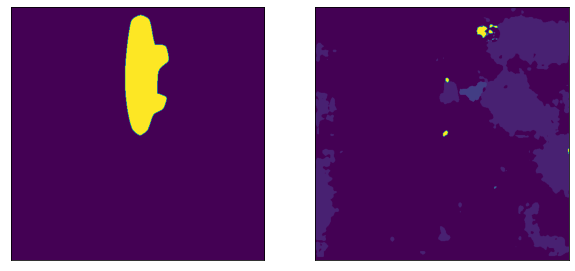

Found 0 points for DPT/gestalt_shapegen/84.


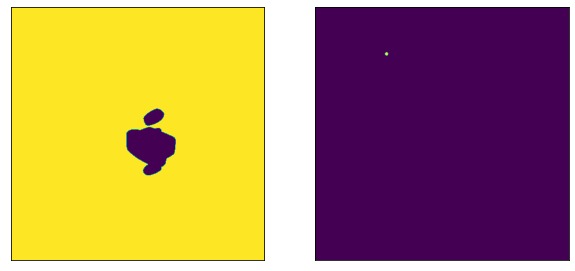

Found 1 points for DPT/gestalt_shapegen/85.
Found 0 points for DPT/gestalt_shapegen/86.


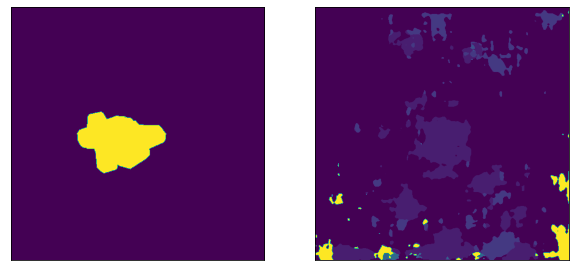

Found 0 points for DPT/gestalt_shapegen/87.


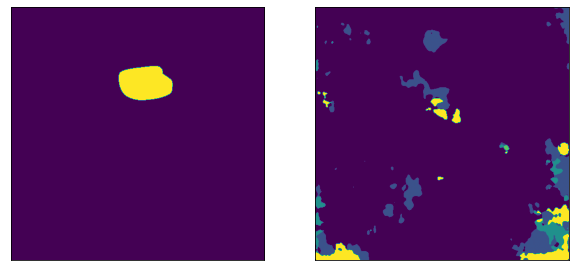

Found 1 points for DPT/gestalt_shapegen/88.
Found 2 points for DPT/gestalt_shapegen/89.
Found 0 points for DPT/gestalt_shapegen/90.


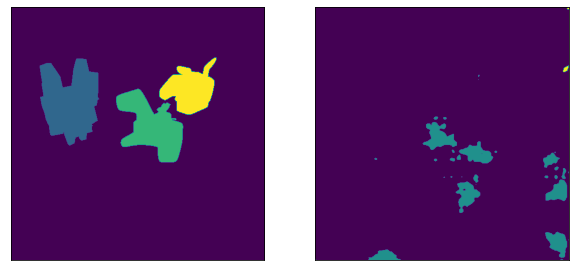

Found 0 points for DPT/gestalt_shapegen/91.


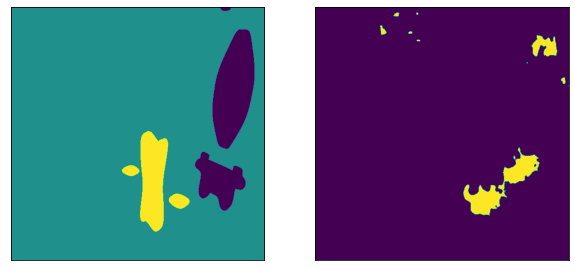

Found 0 points for DPT/gestalt_shapegen/92.


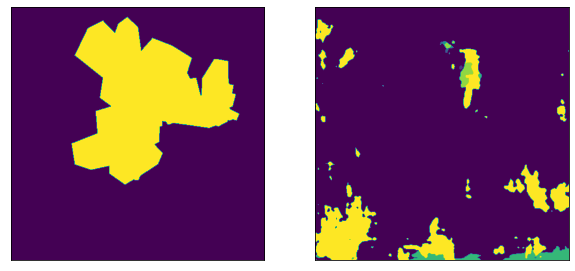

Found 2 points for DPT/gestalt_shapegen/93.
Found 0 points for DPT/gestalt_shapegen/94.


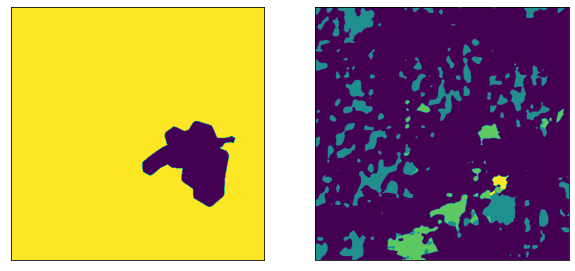

Found 0 points for DPT/gestalt_shapegen/95.


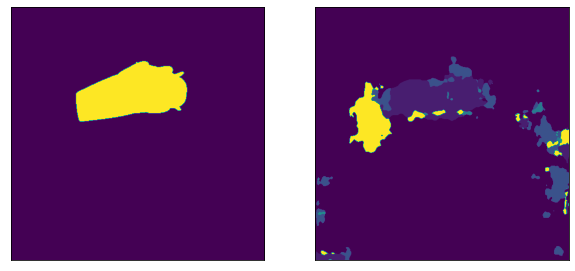

Found 1 points for DPT/gestalt_shapegen/96.
Found 0 points for DPT/gestalt_shapegen/97.


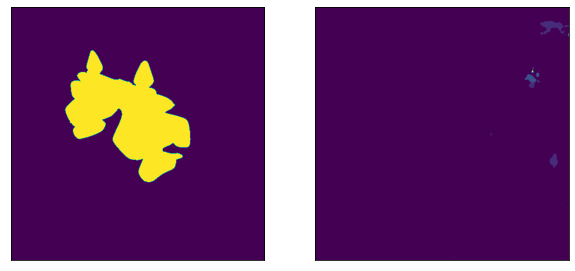

Found 2 points for DPT/gestalt_shapegen/98.
Found 4 points for DPT/gestalt_shapegen/99.


  0%|          | 0/100 [00:00<?, ?it/s]

Found 1 points for DPT/NSD/0.


<Figure size 720x576 with 0 Axes>

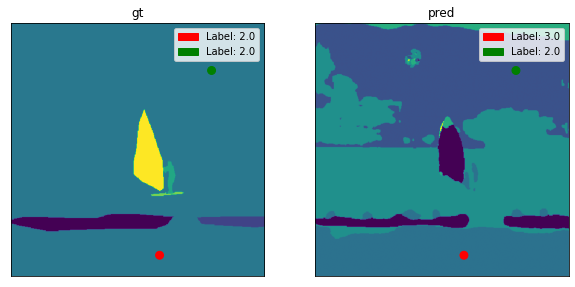

Found 1 points for DPT/NSD/1.
Found 2 points for DPT/NSD/2.
Found 1 points for DPT/NSD/3.
Found 1 points for DPT/NSD/4.
Found 2 points for DPT/NSD/5.
Found 3 points for DPT/NSD/6.
Found 5 points for DPT/NSD/7.
Found 1 points for DPT/NSD/8.
Found 4 points for DPT/NSD/9.
Found 1 points for DPT/NSD/10.
Found 7 points for DPT/NSD/11.
Found 2 points for DPT/NSD/12.
Found 2 points for DPT/NSD/13.
Found 2 points for DPT/NSD/14.
Found 7 points for DPT/NSD/15.
Found 2 points for DPT/NSD/16.
Found 0 points for DPT/NSD/17.


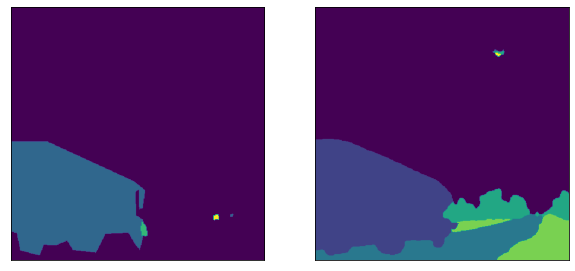

Found 2 points for DPT/NSD/18.
Found 1 points for DPT/NSD/19.
Found 2 points for DPT/NSD/20.


<Figure size 720x576 with 0 Axes>

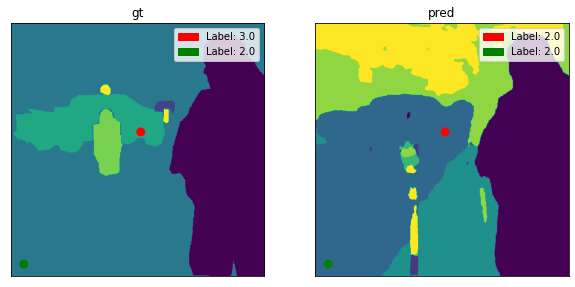

<Figure size 720x576 with 0 Axes>

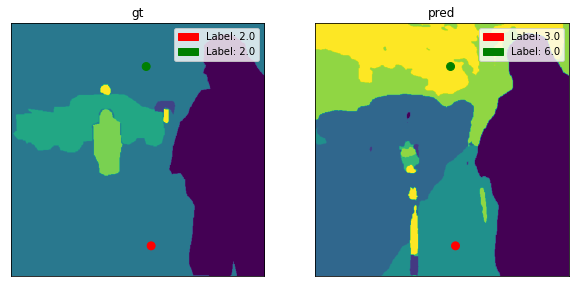

Found 4 points for DPT/NSD/21.
Found 4 points for DPT/NSD/22.
Found 2 points for DPT/NSD/23.
Found 1 points for DPT/NSD/24.
Found 2 points for DPT/NSD/25.
Found 1 points for DPT/NSD/26.
Found 5 points for DPT/NSD/27.
Found 0 points for DPT/NSD/28.


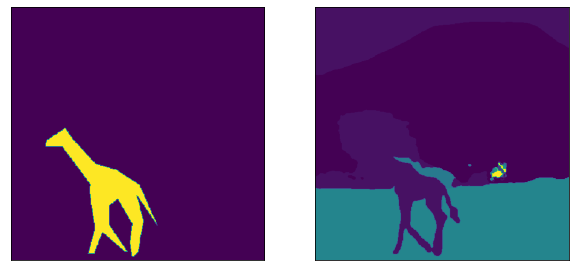

Found 1 points for DPT/NSD/29.
Found 7 points for DPT/NSD/30.
Found 1 points for DPT/NSD/31.
Found 0 points for DPT/NSD/32.


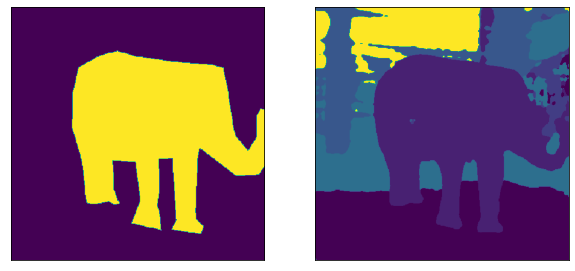

Found 5 points for DPT/NSD/33.
Found 1 points for DPT/NSD/34.
Found 2 points for DPT/NSD/35.
Found 2 points for DPT/NSD/36.
Found 2 points for DPT/NSD/37.
Found 2 points for DPT/NSD/38.
Found 1 points for DPT/NSD/39.
Found 0 points for DPT/NSD/40.


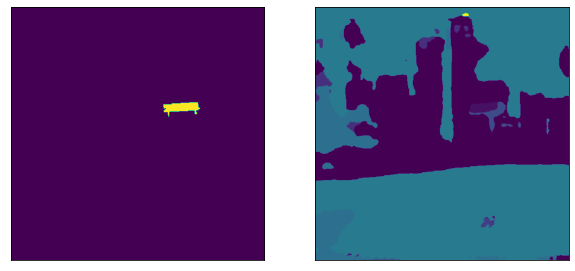

Found 1 points for DPT/NSD/41.
Found 4 points for DPT/NSD/42.
Found 4 points for DPT/NSD/43.
Found 1 points for DPT/NSD/44.
Found 4 points for DPT/NSD/45.
Found 1 points for DPT/NSD/46.
Found 3 points for DPT/NSD/47.
Found 2 points for DPT/NSD/48.
Found 6 points for DPT/NSD/49.
Found 1 points for DPT/NSD/50.
Found 1 points for DPT/NSD/51.
Found 5 points for DPT/NSD/52.
Found 0 points for DPT/NSD/53.


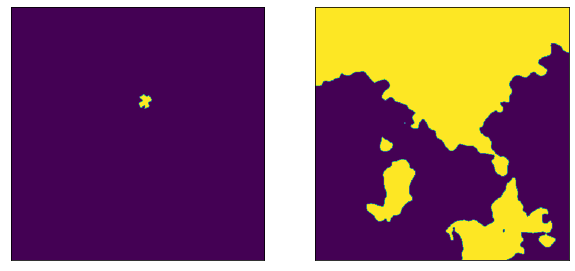

Found 5 points for DPT/NSD/54.
Found 4 points for DPT/NSD/55.
Found 8 points for DPT/NSD/56.
Found 1 points for DPT/NSD/57.
Found 1 points for DPT/NSD/58.
Found 3 points for DPT/NSD/59.
Found 0 points for DPT/NSD/60.


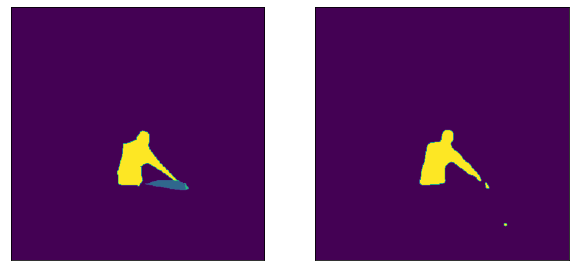

Found 1 points for DPT/NSD/61.
Found 4 points for DPT/NSD/62.
Found 1 points for DPT/NSD/63.
Found 2 points for DPT/NSD/64.
Found 0 points for DPT/NSD/65.


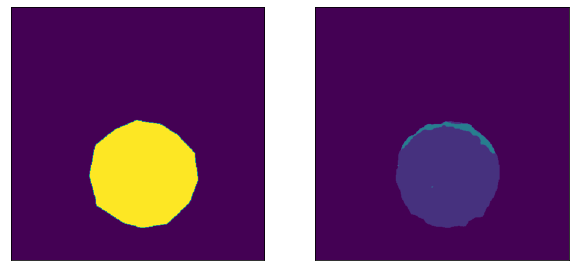

Found 2 points for DPT/NSD/66.
Found 0 points for DPT/NSD/67.


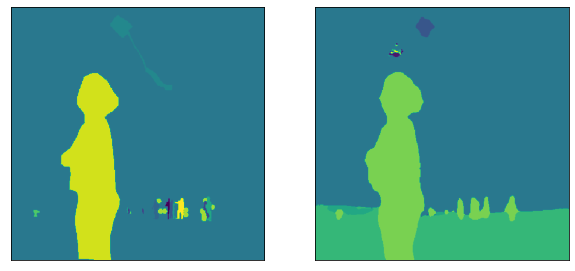

Found 1 points for DPT/NSD/68.
Found 0 points for DPT/NSD/69.


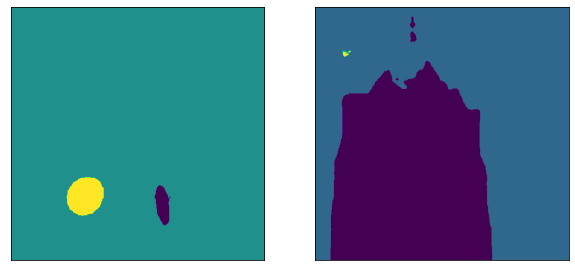

Found 0 points for DPT/NSD/70.


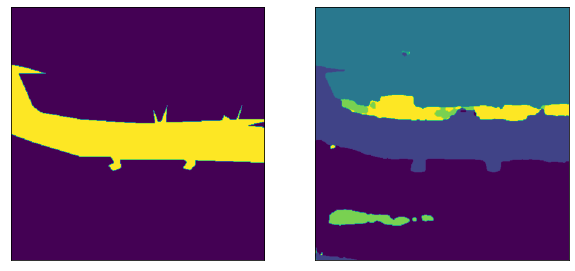

Found 1 points for DPT/NSD/71.
Found 3 points for DPT/NSD/72.
Found 2 points for DPT/NSD/73.
Found 4 points for DPT/NSD/74.
Found 2 points for DPT/NSD/75.
Found 5 points for DPT/NSD/76.
Found 3 points for DPT/NSD/77.
Found 3 points for DPT/NSD/78.
Found 1 points for DPT/NSD/79.
Found 2 points for DPT/NSD/80.


<Figure size 720x576 with 0 Axes>

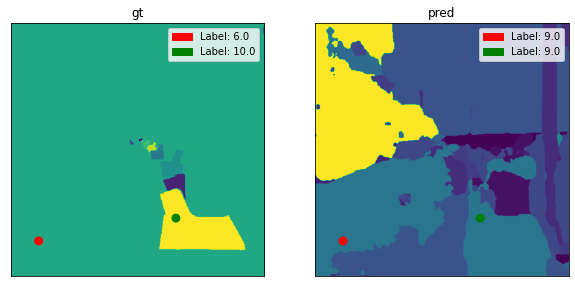

<Figure size 720x576 with 0 Axes>

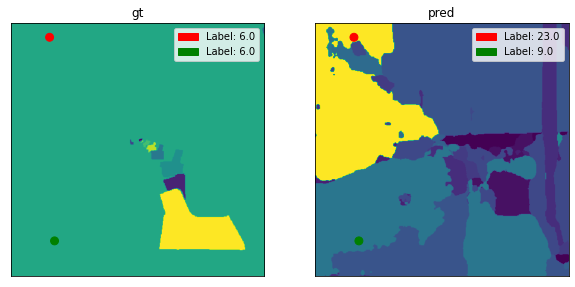

Found 4 points for DPT/NSD/81.
Found 5 points for DPT/NSD/82.
Found 1 points for DPT/NSD/83.
Found 0 points for DPT/NSD/84.


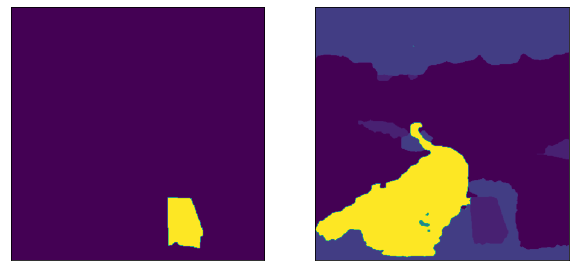

Found 6 points for DPT/NSD/85.
Found 1 points for DPT/NSD/86.
Found 5 points for DPT/NSD/87.
Found 0 points for DPT/NSD/88.


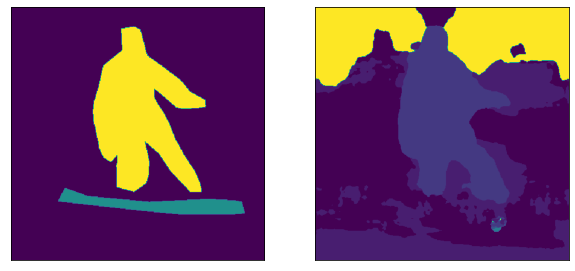

Found 1 points for DPT/NSD/89.
Found 1 points for DPT/NSD/90.
Found 5 points for DPT/NSD/91.
Found 0 points for DPT/NSD/92.


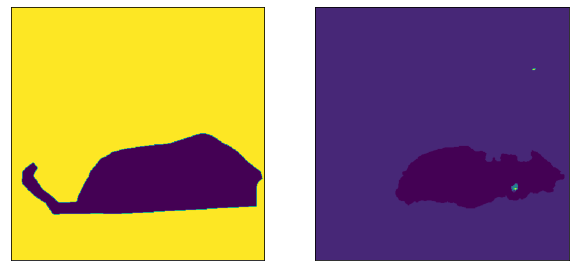

Found 5 points for DPT/NSD/93.
Found 2 points for DPT/NSD/94.
Found 3 points for DPT/NSD/95.
Found 2 points for DPT/NSD/96.
Found 1 points for DPT/NSD/97.
Found 1 points for DPT/NSD/98.
Found 5 points for DPT/NSD/99.


  0%|          | 0/100 [00:00<?, ?it/s]

Found 7 points for DPT/hypersim_v3/0.


<Figure size 720x576 with 0 Axes>

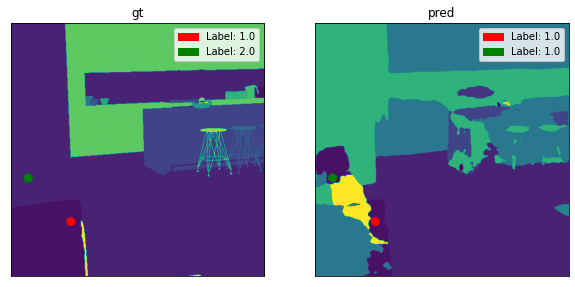

<Figure size 720x576 with 0 Axes>

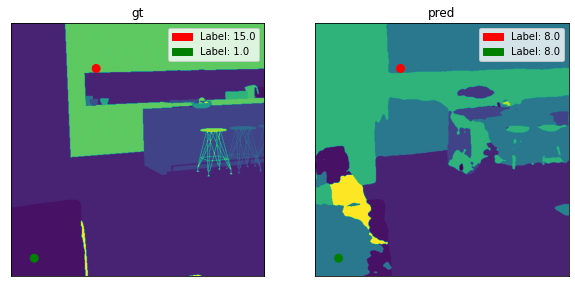

<Figure size 720x576 with 0 Axes>

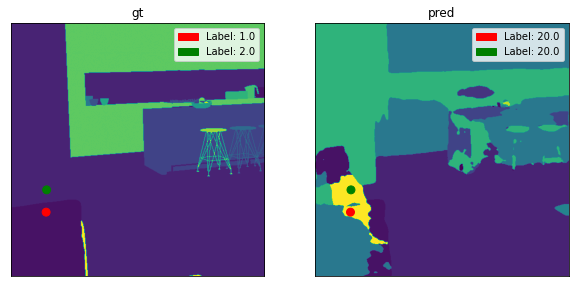

<Figure size 720x576 with 0 Axes>

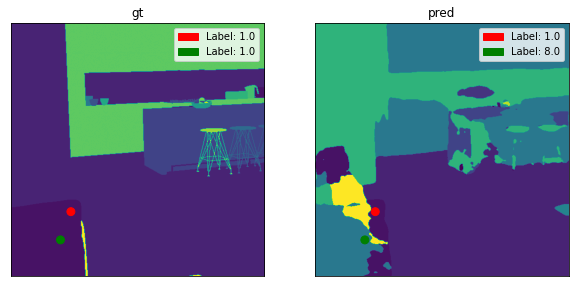

<Figure size 720x576 with 0 Axes>

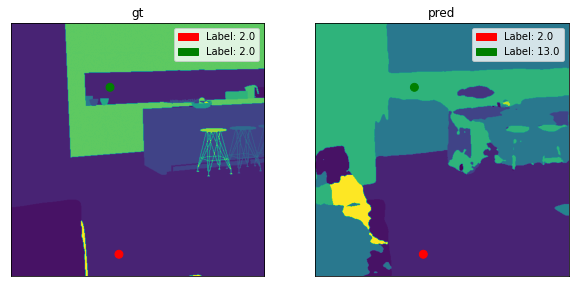

<Figure size 720x576 with 0 Axes>

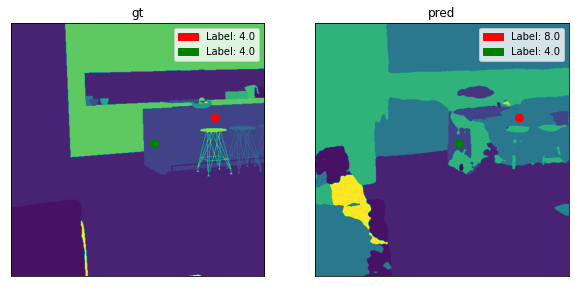

<Figure size 720x576 with 0 Axes>

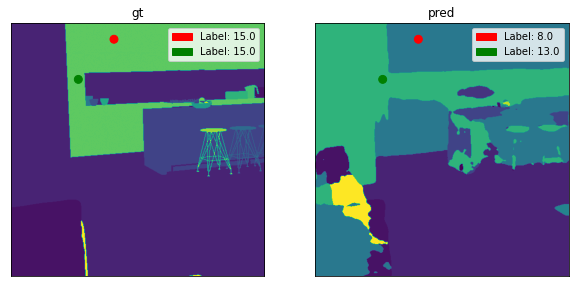

Found 6 points for DPT/hypersim_v3/1.
Found 3 points for DPT/hypersim_v3/2.
Found 2 points for DPT/hypersim_v3/3.
Found 4 points for DPT/hypersim_v3/4.
Found 4 points for DPT/hypersim_v3/5.
Found 1 points for DPT/hypersim_v3/6.
Found 4 points for DPT/hypersim_v3/7.
Found 5 points for DPT/hypersim_v3/8.
Found 3 points for DPT/hypersim_v3/9.
Found 3 points for DPT/hypersim_v3/10.
Found 0 points for DPT/hypersim_v3/11.


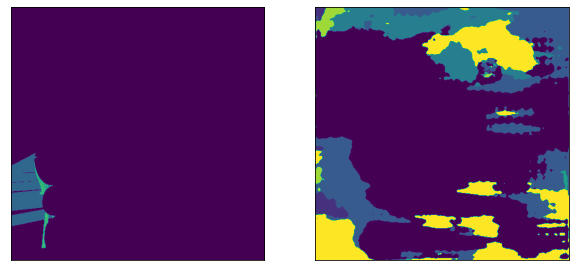

Found 7 points for DPT/hypersim_v3/12.
Found 3 points for DPT/hypersim_v3/13.
Found 1 points for DPT/hypersim_v3/14.
Found 7 points for DPT/hypersim_v3/15.
Found 2 points for DPT/hypersim_v3/16.
Found 0 points for DPT/hypersim_v3/17.


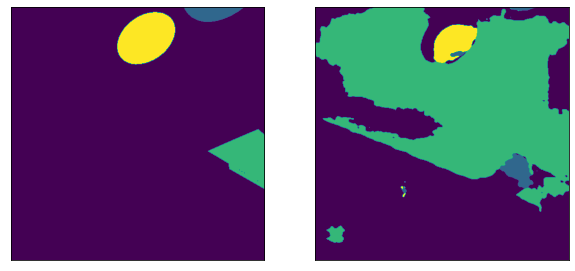

Found 4 points for DPT/hypersim_v3/18.
Found 7 points for DPT/hypersim_v3/19.
Found 5 points for DPT/hypersim_v3/20.


<Figure size 720x576 with 0 Axes>

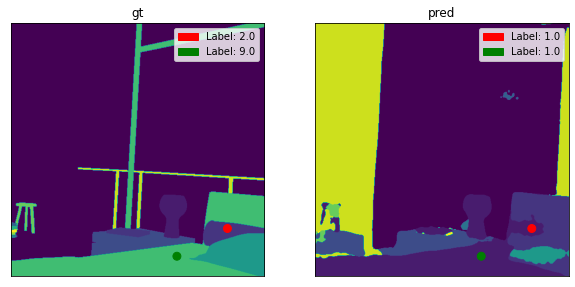

<Figure size 720x576 with 0 Axes>

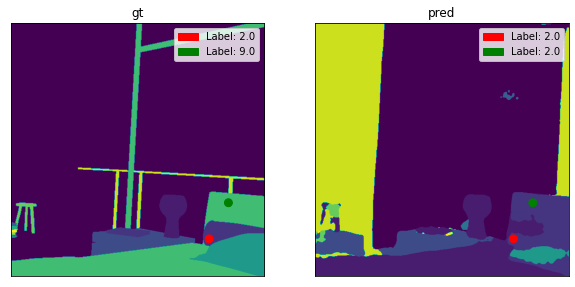

<Figure size 720x576 with 0 Axes>

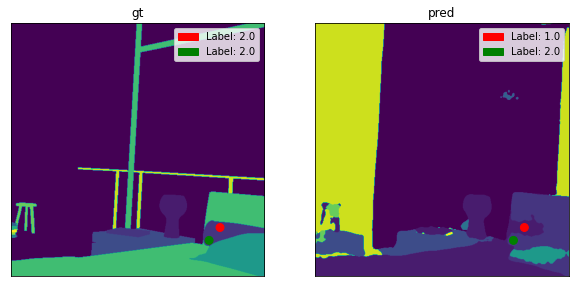

<Figure size 720x576 with 0 Axes>

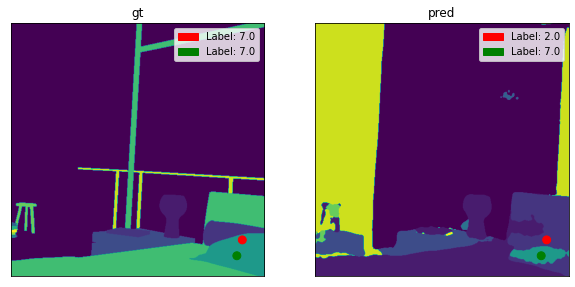

<Figure size 720x576 with 0 Axes>

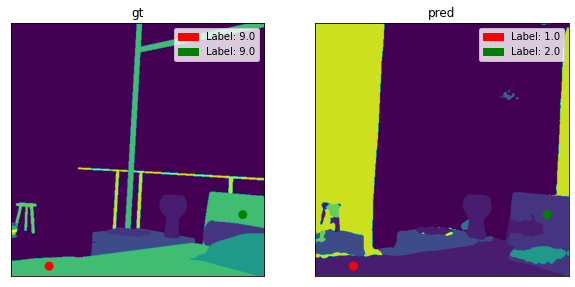

Found 6 points for DPT/hypersim_v3/21.
Found 3 points for DPT/hypersim_v3/22.
Found 1 points for DPT/hypersim_v3/23.
Found 3 points for DPT/hypersim_v3/24.
Found 5 points for DPT/hypersim_v3/25.
Found 4 points for DPT/hypersim_v3/26.
Found 4 points for DPT/hypersim_v3/27.
Found 4 points for DPT/hypersim_v3/28.
Found 2 points for DPT/hypersim_v3/29.
Found 2 points for DPT/hypersim_v3/30.
Found 2 points for DPT/hypersim_v3/31.
Found 9 points for DPT/hypersim_v3/32.
Found 5 points for DPT/hypersim_v3/33.
Found 2 points for DPT/hypersim_v3/34.
Found 5 points for DPT/hypersim_v3/35.
Found 8 points for DPT/hypersim_v3/36.
Found 0 points for DPT/hypersim_v3/37.


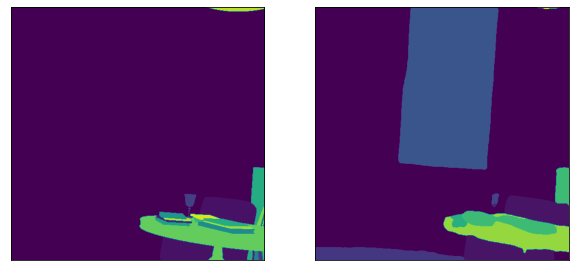

Found 2 points for DPT/hypersim_v3/38.
Found 1 points for DPT/hypersim_v3/39.
Found 5 points for DPT/hypersim_v3/40.


<Figure size 720x576 with 0 Axes>

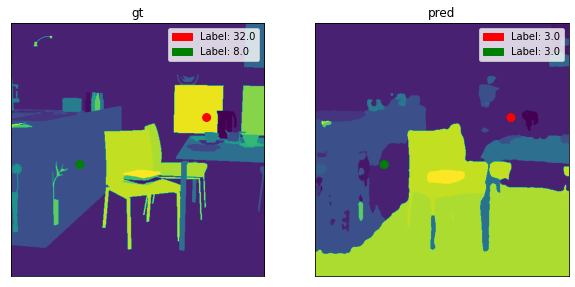

<Figure size 720x576 with 0 Axes>

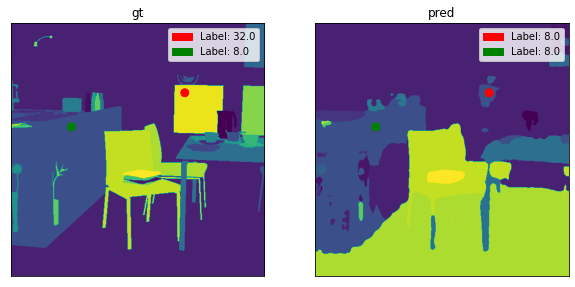

<Figure size 720x576 with 0 Axes>

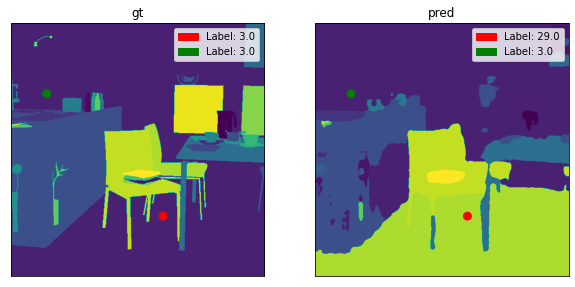

<Figure size 720x576 with 0 Axes>

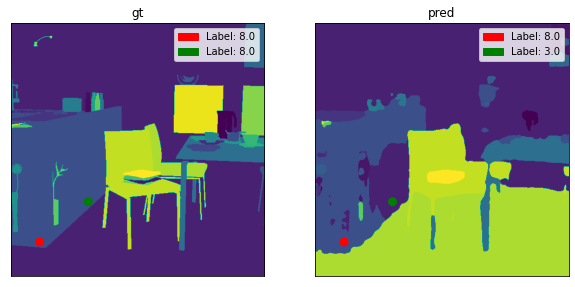

<Figure size 720x576 with 0 Axes>

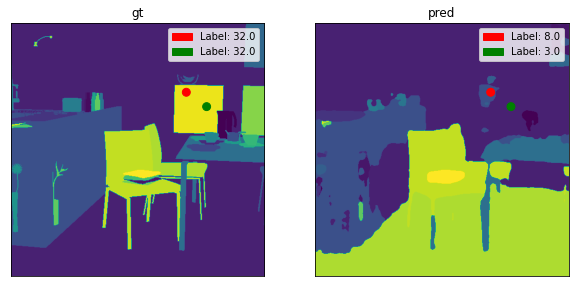

Found 1 points for DPT/hypersim_v3/41.
Found 2 points for DPT/hypersim_v3/42.
Found 1 points for DPT/hypersim_v3/43.
Found 3 points for DPT/hypersim_v3/44.
Found 3 points for DPT/hypersim_v3/45.
Found 1 points for DPT/hypersim_v3/46.
Found 0 points for DPT/hypersim_v3/47.


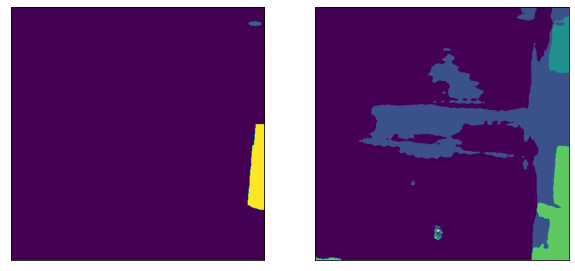

Found 2 points for DPT/hypersim_v3/48.
Found 11 points for DPT/hypersim_v3/49.
Found 0 points for DPT/hypersim_v3/50.


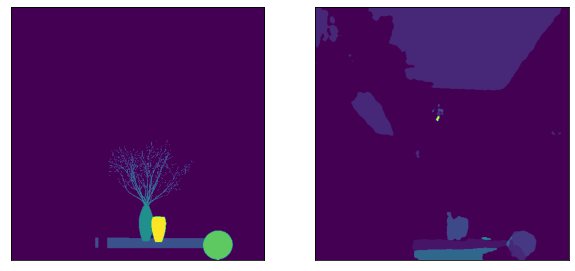

Found 4 points for DPT/hypersim_v3/51.
Found 4 points for DPT/hypersim_v3/52.
Found 3 points for DPT/hypersim_v3/53.
Found 4 points for DPT/hypersim_v3/54.
Found 4 points for DPT/hypersim_v3/55.
Found 3 points for DPT/hypersim_v3/56.
Found 6 points for DPT/hypersim_v3/57.
Found 1 points for DPT/hypersim_v3/58.
Found 3 points for DPT/hypersim_v3/59.
Found 4 points for DPT/hypersim_v3/60.


<Figure size 720x576 with 0 Axes>

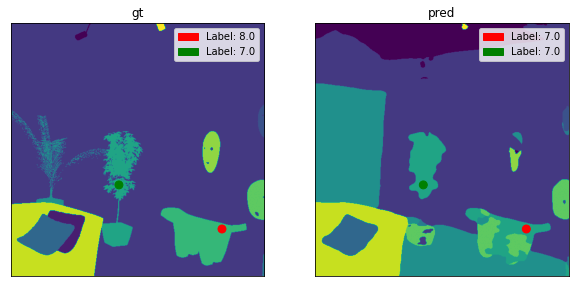

<Figure size 720x576 with 0 Axes>

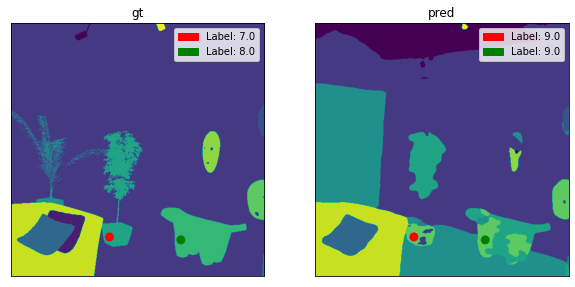

<Figure size 720x576 with 0 Axes>

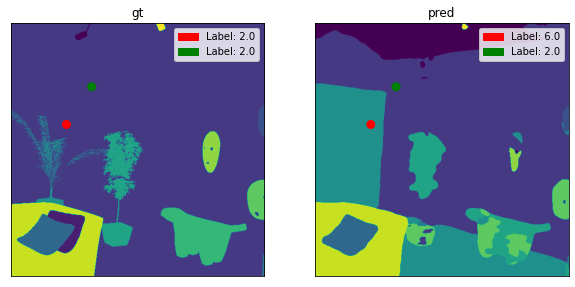

<Figure size 720x576 with 0 Axes>

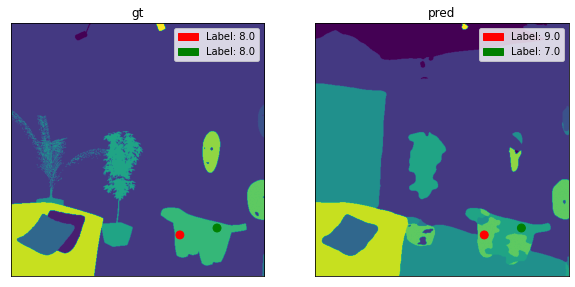

Found 3 points for DPT/hypersim_v3/61.
Found 3 points for DPT/hypersim_v3/62.
Found 5 points for DPT/hypersim_v3/63.
Found 4 points for DPT/hypersim_v3/64.
Found 5 points for DPT/hypersim_v3/65.
Found 4 points for DPT/hypersim_v3/66.
Found 0 points for DPT/hypersim_v3/67.


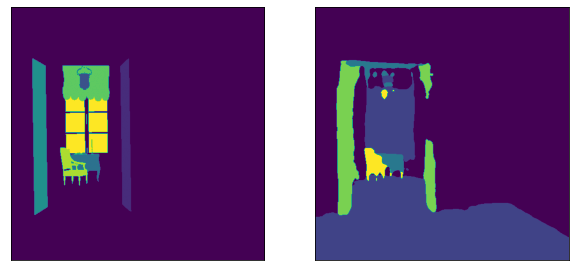

Found 3 points for DPT/hypersim_v3/68.
Found 4 points for DPT/hypersim_v3/69.
Found 2 points for DPT/hypersim_v3/70.
Found 4 points for DPT/hypersim_v3/71.
Found 1 points for DPT/hypersim_v3/72.
Found 3 points for DPT/hypersim_v3/73.
Found 4 points for DPT/hypersim_v3/74.
Found 4 points for DPT/hypersim_v3/75.
Found 0 points for DPT/hypersim_v3/76.


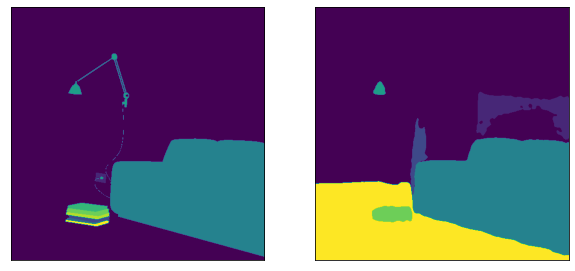

Found 5 points for DPT/hypersim_v3/77.
Found 2 points for DPT/hypersim_v3/78.
Found 0 points for DPT/hypersim_v3/79.


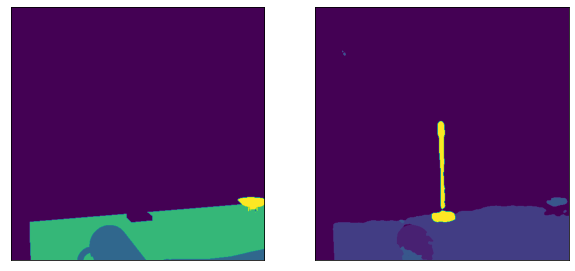

Found 2 points for DPT/hypersim_v3/80.


<Figure size 720x576 with 0 Axes>

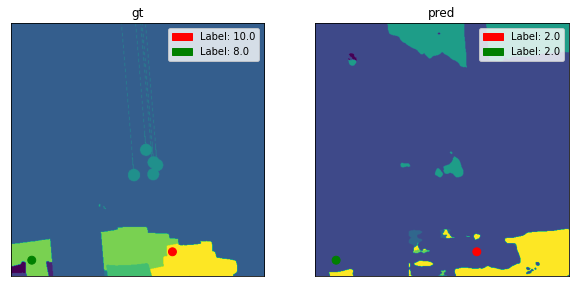

<Figure size 720x576 with 0 Axes>

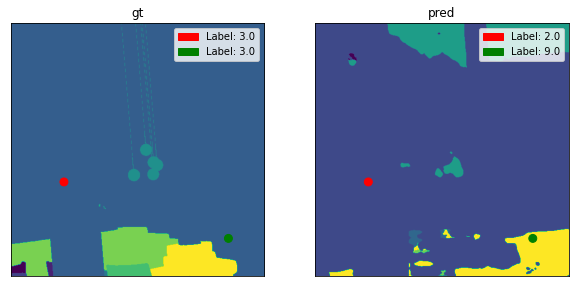

Found 5 points for DPT/hypersim_v3/81.
Found 3 points for DPT/hypersim_v3/82.
Found 0 points for DPT/hypersim_v3/83.


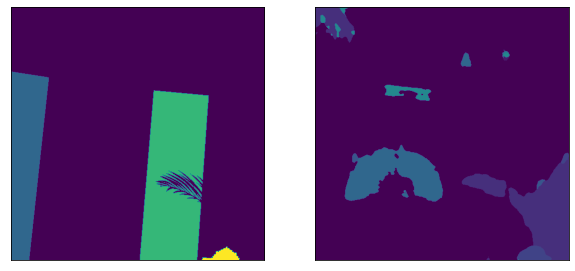

Found 2 points for DPT/hypersim_v3/84.
Found 2 points for DPT/hypersim_v3/85.
Found 3 points for DPT/hypersim_v3/86.
Found 2 points for DPT/hypersim_v3/87.
Found 2 points for DPT/hypersim_v3/88.
Found 1 points for DPT/hypersim_v3/89.
Found 4 points for DPT/hypersim_v3/90.
Found 3 points for DPT/hypersim_v3/91.
Found 3 points for DPT/hypersim_v3/92.
Found 2 points for DPT/hypersim_v3/93.
Found 4 points for DPT/hypersim_v3/94.
Found 2 points for DPT/hypersim_v3/95.
Found 2 points for DPT/hypersim_v3/96.
Found 6 points for DPT/hypersim_v3/97.
Found 0 points for DPT/hypersim_v3/98.


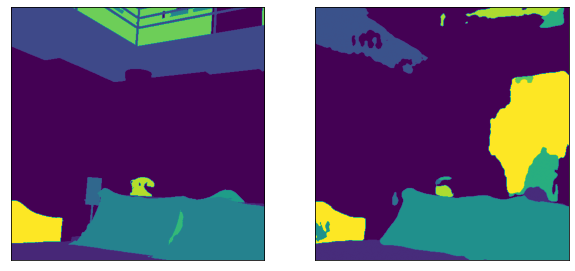

Found 4 points for DPT/hypersim_v3/99.


  0%|          | 0/100 [00:00<?, ?it/s]

Found 3 points for DPT/TDW/0.


<Figure size 720x576 with 0 Axes>

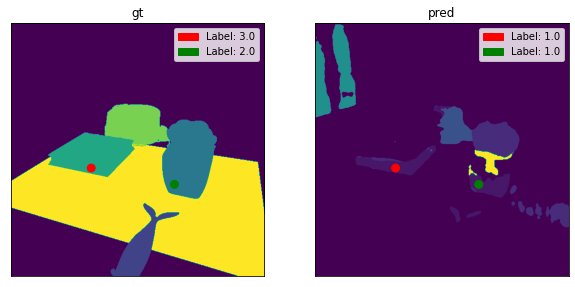

<Figure size 720x576 with 0 Axes>

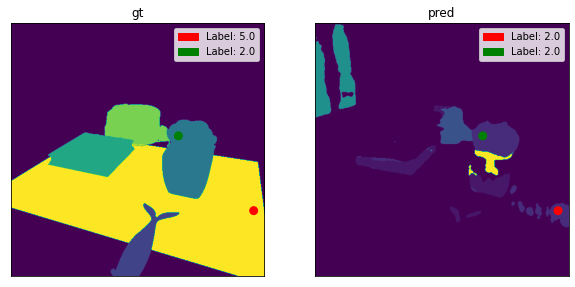

<Figure size 720x576 with 0 Axes>

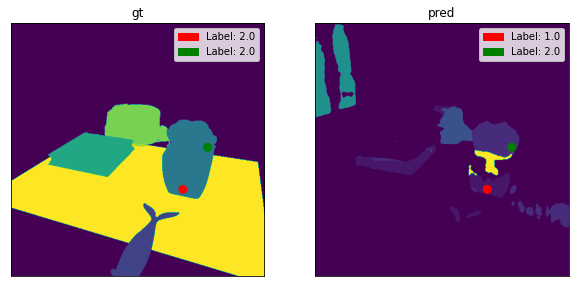

Found 3 points for DPT/TDW/1.
Found 3 points for DPT/TDW/2.
Found 7 points for DPT/TDW/3.
Found 3 points for DPT/TDW/4.
Found 5 points for DPT/TDW/5.
Found 1 points for DPT/TDW/6.
Found 2 points for DPT/TDW/7.
Found 2 points for DPT/TDW/8.
Found 5 points for DPT/TDW/9.
Found 4 points for DPT/TDW/10.
Found 4 points for DPT/TDW/11.
Found 6 points for DPT/TDW/12.
Found 4 points for DPT/TDW/13.
Found 3 points for DPT/TDW/14.
Found 5 points for DPT/TDW/15.
Found 6 points for DPT/TDW/16.
Found 8 points for DPT/TDW/17.
Found 5 points for DPT/TDW/18.
Found 3 points for DPT/TDW/19.
Found 1 points for DPT/TDW/20.


<Figure size 720x576 with 0 Axes>

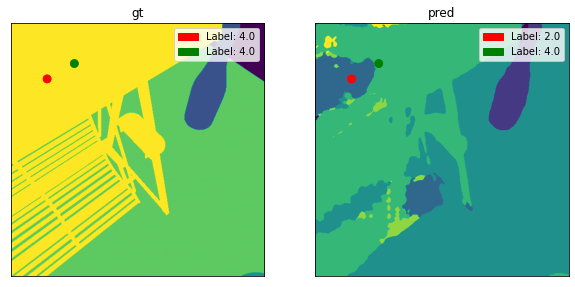

Found 0 points for DPT/TDW/21.


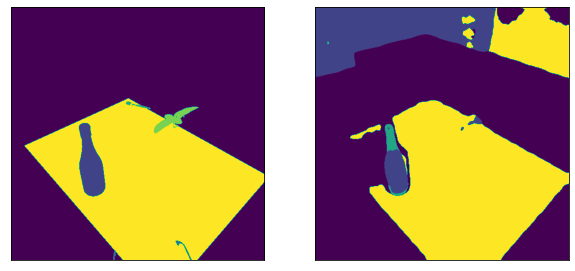

Found 3 points for DPT/TDW/22.
Found 2 points for DPT/TDW/23.
Found 3 points for DPT/TDW/24.
Found 5 points for DPT/TDW/25.
Found 3 points for DPT/TDW/26.
Found 3 points for DPT/TDW/27.
Found 2 points for DPT/TDW/28.
Found 0 points for DPT/TDW/29.


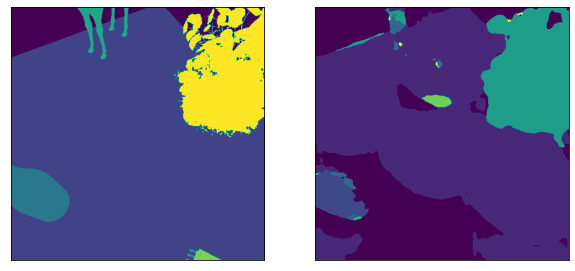

Found 7 points for DPT/TDW/30.
Found 2 points for DPT/TDW/31.
Found 3 points for DPT/TDW/32.
Found 5 points for DPT/TDW/33.
Found 2 points for DPT/TDW/34.
Found 3 points for DPT/TDW/35.
Found 2 points for DPT/TDW/36.
Found 5 points for DPT/TDW/37.
Found 2 points for DPT/TDW/38.
Found 6 points for DPT/TDW/39.
Found 2 points for DPT/TDW/40.


<Figure size 720x576 with 0 Axes>

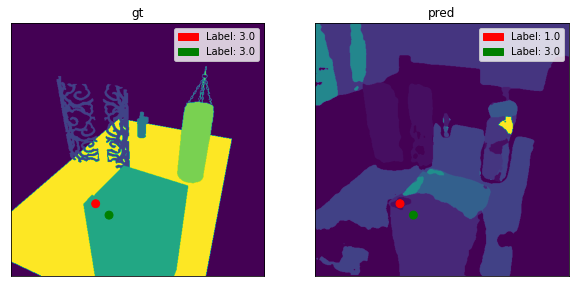

<Figure size 720x576 with 0 Axes>

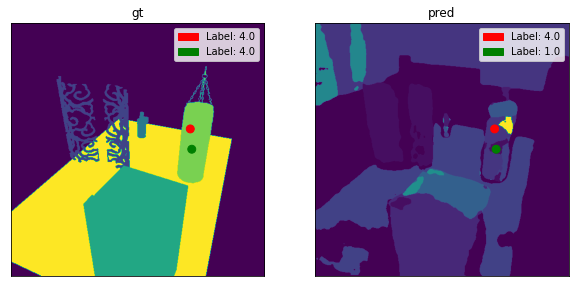

Found 5 points for DPT/TDW/41.
Found 0 points for DPT/TDW/42.


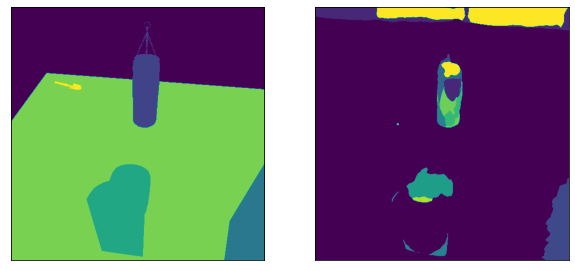

Found 5 points for DPT/TDW/43.
Found 8 points for DPT/TDW/44.
Found 5 points for DPT/TDW/45.
Found 2 points for DPT/TDW/46.
Found 4 points for DPT/TDW/47.
Found 4 points for DPT/TDW/48.
Found 5 points for DPT/TDW/49.
Found 1 points for DPT/TDW/50.
Found 7 points for DPT/TDW/51.
Found 1 points for DPT/TDW/52.
Found 2 points for DPT/TDW/53.
Found 3 points for DPT/TDW/54.
Found 7 points for DPT/TDW/55.
Found 2 points for DPT/TDW/56.
Found 1 points for DPT/TDW/57.
Found 3 points for DPT/TDW/58.
Found 6 points for DPT/TDW/59.
Found 5 points for DPT/TDW/60.


<Figure size 720x576 with 0 Axes>

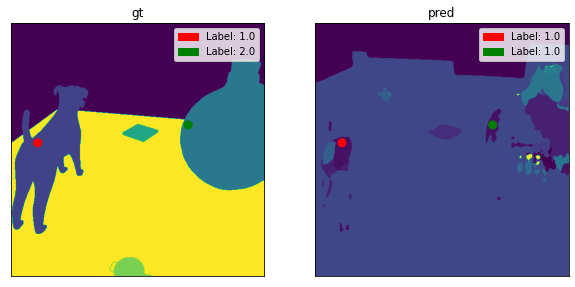

<Figure size 720x576 with 0 Axes>

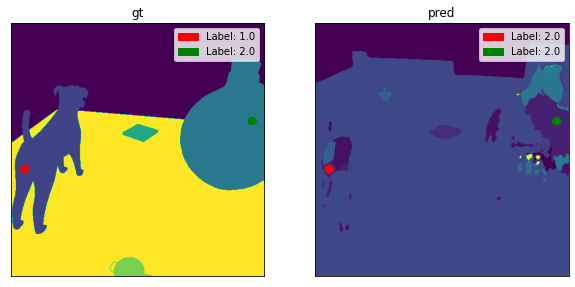

<Figure size 720x576 with 0 Axes>

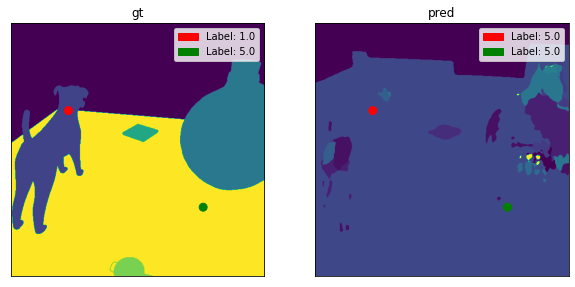

<Figure size 720x576 with 0 Axes>

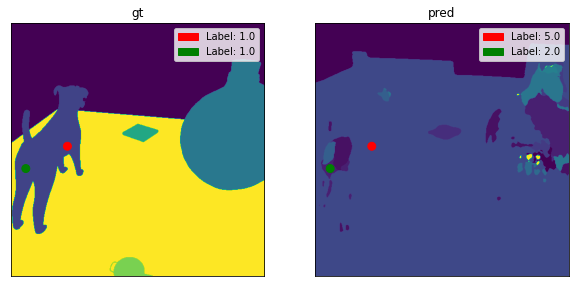

<Figure size 720x576 with 0 Axes>

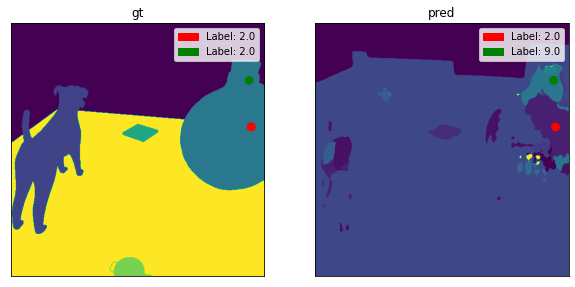

Found 4 points for DPT/TDW/61.
Found 5 points for DPT/TDW/62.
Found 4 points for DPT/TDW/63.
Found 3 points for DPT/TDW/64.
Found 5 points for DPT/TDW/65.
Found 5 points for DPT/TDW/66.
Found 5 points for DPT/TDW/67.
Found 4 points for DPT/TDW/68.
Found 1 points for DPT/TDW/69.
Found 2 points for DPT/TDW/70.
Found 2 points for DPT/TDW/71.
Found 1 points for DPT/TDW/72.
Found 2 points for DPT/TDW/73.
Found 3 points for DPT/TDW/74.
Found 4 points for DPT/TDW/75.
Found 3 points for DPT/TDW/76.
Found 2 points for DPT/TDW/77.
Found 2 points for DPT/TDW/78.
Found 3 points for DPT/TDW/79.
Found 4 points for DPT/TDW/80.


<Figure size 720x576 with 0 Axes>

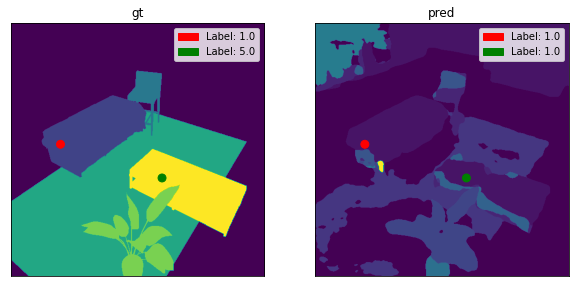

<Figure size 720x576 with 0 Axes>

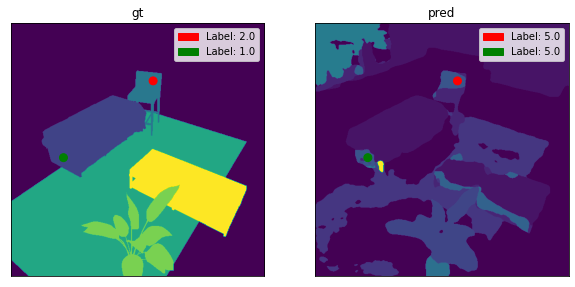

<Figure size 720x576 with 0 Axes>

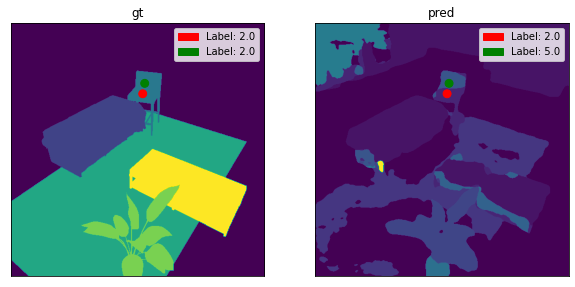

<Figure size 720x576 with 0 Axes>

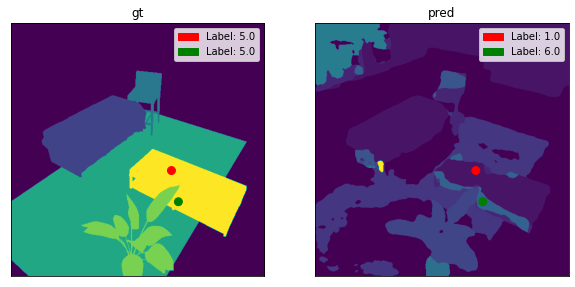

Found 4 points for DPT/TDW/81.
Found 2 points for DPT/TDW/82.
Found 3 points for DPT/TDW/83.
Found 4 points for DPT/TDW/84.
Found 2 points for DPT/TDW/85.
Found 5 points for DPT/TDW/86.
Found 4 points for DPT/TDW/87.
Found 4 points for DPT/TDW/88.
Found 4 points for DPT/TDW/89.
Found 3 points for DPT/TDW/90.
Found 2 points for DPT/TDW/91.
Found 2 points for DPT/TDW/92.
Found 6 points for DPT/TDW/93.
Found 4 points for DPT/TDW/94.
Found 4 points for DPT/TDW/95.
Found 2 points for DPT/TDW/96.
Found 3 points for DPT/TDW/97.
Found 3 points for DPT/TDW/98.
Found 3 points for DPT/TDW/99.


In [308]:
adversarial_points = {}
for model in ["EISEN", "DPT"]:
    adversarial_points[model] = {}
    for dataset in ["gestalt_shapegen", "NSD", "hypersim_v3", "TDW"]:
        adversarial_points[model][dataset] = []
        for image in tqdm(range(100)):
            gt, pred = load_two(model, dataset, image)
            points = adversarial_sample(gt, pred)
            print(f"Found {len(points)} points for {model}/{dataset}/{image}.")
            adversarial_points[model][dataset].append(points)
            if image % 20 == 0: 
                for i in range(len(points)):
                    fig = plt.figure(figsize=(10, 8))
                    utils.plot_pair(gt, pred, ["gt", "pred"], points[i:i+1])
                    plt.show()
            if not len(points):
                utils.plot_pair(gt, pred)
                plt.show()

In [313]:
def evaluate(gt, mask0, mask1, points):
    scores = [0, 0]
    if len(points) == 0:
        return [np.nan, np.nan]

    for pairs in points:
        (x0, y0), (x1, y1) = pairs
        gt_vals = [gt[y0, x0], gt[y1, x1]]
        vals0 = [mask0[y0, x0], mask0[y1, x1]]
        vals1 = [mask1[y0, x0], mask1[y1, x1]]
        if gt_vals[0] == gt_vals[1]:
            if vals0[0] == vals0[1]:
                scores[0] += 1
            if vals1[0] == vals1[1]:
                scores[1] += 1
        
        if gt_vals[0] != gt_vals[1]:
            if vals0[0] != vals0[1]:
                scores[0] += 1
            if vals1[0] != vals1[1]:
                scores[1] += 1
    
    return scores

In [314]:
scores = []
for dataset in ["TDW", "hypersim_v3", "NSD", "gestalt_shapegen"]:
    for image in tqdm(range(100)):
        gt, eisen_pred = load_two("EISEN", dataset, image)
        _, dpt_pred = load_two("DPT", dataset, image)
        all_pts = adversarial_points["EISEN"][dataset][image]
        dpt_pts = adversarial_points["DPT"][dataset][image]
        all_pts.extend(dpt_pts)
        eisen_score, dpt_score = evaluate(gt, eisen_pred, dpt_pred, all_pts)
        scores.append({"dataset": dataset, "image_id": image, "model": "EISEN", "score": eisen_score})
        scores.append({"dataset": dataset, "image_id": image, "model": "DPT", "score": dpt_score})


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

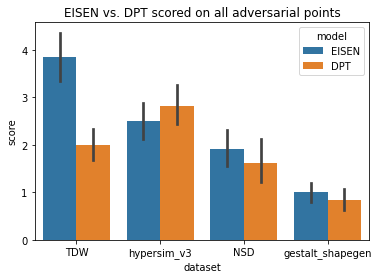

In [318]:
df = pd.DataFrame(scores)
sns.barplot(y="score", x="dataset", hue="model", data=df)
plt.title("EISEN vs. DPT scored on all adversarial points")
plt.show()

In [335]:
def evaluate_single(gt, mask,  points):
    score = 0
    if len(points) == 0:
        return np.nan

    for pairs in points:
        (x0, y0), (x1, y1) = pairs
        gt_vals = [gt[y0, x0], gt[y1, x1]]
        vals = [mask[y0, x0], mask[y1, x1]]

        if gt_vals[0] == gt_vals[1]:
            if vals[0] == vals[1]:
                score += 1
           
        if gt_vals[0] != gt_vals[1]:
            if vals[0] != vals[1]:
                score += 1

    return score / len(points)

In [336]:
single_scores = []
for dataset in ["TDW", "hypersim_v3", "NSD", "gestalt_shapegen"]:
    for image in tqdm(range(100)):
        gt, eisen_pred = load_two("EISEN", dataset, image)
        _, dpt_pred = load_two("DPT", dataset, image)
        eisen_pts = adversarial_points["EISEN"][dataset][image]
        dpt_pts = adversarial_points["DPT"][dataset][image]
        eisen_score = evaluate_single(gt, eisen_pred, dpt_pts)
        dpt_score = evaluate_single(gt, dpt_pred, eisen_pts)
        single_scores.append({"dataset": dataset, "image_id": image, "model": "EISEN", "score": eisen_score})
        single_scores.append({"dataset": dataset, "image_id": image, "model": "DPT", "score": dpt_score})


  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

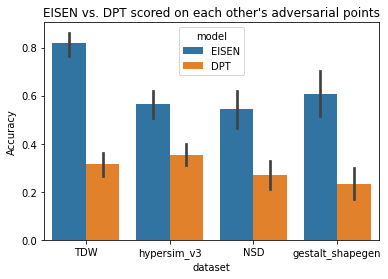

In [337]:
df = pd.DataFrame(single_scores)
df["score"].astype(np.float32)
sns.barplot(y="score", x="dataset", hue="model", data=df)
plt.ylabel("Accuracy")
plt.title("EISEN vs. DPT scored on each other's adversarial points")
plt.show()